In [202]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Drive Cycle construction using Monte Carlo method


## 1. Introduction
     A driving cycle,is represented by vehicle speed versus time.

* It is a velocity- time profile that describes driving characteristics of specific type of vehicles under real- world driving condition.


* Driving cycles are important components for evaluating vehicles and play a fundamental role in vehicle design since the driving cycle affects the cost, fuel consumption, and the emissions of vehicles.

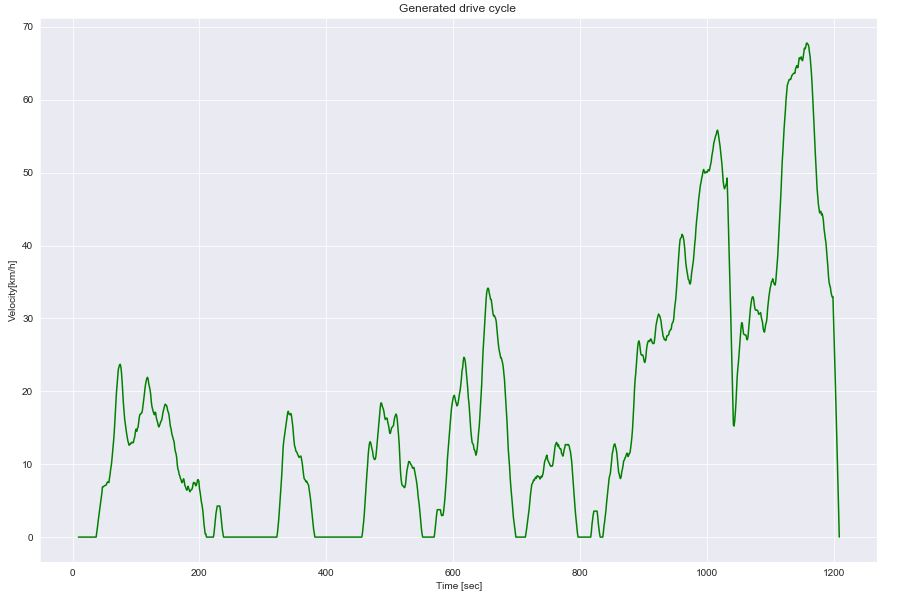

In [388]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
from functools import reduce
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 7000)

from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly
import seaborn as sns
sns.set_style("darkgrid")
import random
import bisect
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from sklearn import metrics

init_notebook_mode(connected=True)

In [204]:
sampling_rate=10
channel_data_path=r'data\channel_data'
raw_file=r'data\Sample_data.csv'

In [205]:
full_data=pd.read_csv(raw_file)


#### Take a quick glance of data :

In [206]:
full_data['accel']=(full_data['Velocity']-full_data['Velocity'].shift(1))/(1)
full_data['vehicle_speed']=full_data['Velocity']
full_data

TCU Timestamp IST  GPS Latitude - TCU  GPS Longitude - TCU  \
0      2019-09-18T09:23:58.000+05:30              28.498               77.073   
1      2019-09-18T09:23:59.000+05:30              28.498               77.073   
2      2019-09-18T09:24:00.000+05:30              28.498               77.073   
3      2019-09-18T09:24:01.000+05:30              28.498               77.073   
4      2019-09-18T09:24:02.000+05:30              28.498               77.073   
...                              ...                 ...                  ...   
41918  2019-09-19T13:34:43.000+05:30              28.497               77.073   
41919  2019-09-19T13:34:44.000+05:30              28.497               77.073   
41920  2019-09-19T13:34:45.000+05:30              28.497               77.073   
41921  2019-09-19T13:34:46.000+05:30              28.497               77.073   
41922  2019-09-19T13:34:47.000+05:30              28.497               77.073   

       Velocity  Message Identifier  Ignition Counter  accel  vehicle_speed  
0         0.000                 999              4215    nan          0.000  
1         0.000                 999              4215  0.000          0.000  
2         0.000                  99              4215  0.000          0.000  
3         0.000                  99              4215  0.000          0.000  
4         0.000                  99              4215  0.000          0.000  
...         ...                 ...               ...    ...            ...  
41918     8.710                  99              4229 -0.060          8.710  
41919     9.890                  99              4229  1.180          9.890  
41920    10.530                  99              4229  0.640         10.530  
41921    11.390                  99              4229  0.860         11.390  
41922    12.400                  99              4229  1.010         12.400  

[41923 rows x 8 columns]

In [207]:
full_data = full_data[full_data['accel'] <10]
full_data = full_data[full_data['accel'] >-10]
full_data.reset_index(inplace=True, drop =True)

In [208]:
acc_limit=0.1
dec_limit=-0.1

In [209]:
# full_data = full_data[1:95000]

### 2.1 Categorization in 5 driving micro driving fragments

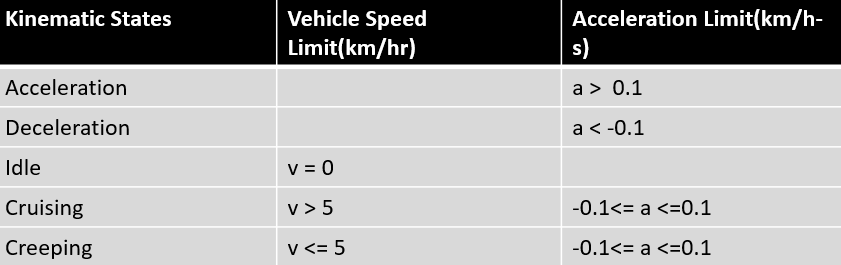

In [210]:
full_data['state']=np.nan
full_data.at[full_data.loc[np.where(full_data['accel']>=acc_limit)].index, 'state'] = 'a'
full_data.at[full_data.loc[np.where(full_data['accel']<=dec_limit)].index, 'state'] = 'd'
full_data.at[full_data.loc[np.where((full_data['accel']>dec_limit) & (full_data['accel']<acc_limit) & (full_data['vehicle_speed']>5))].index, 'state'] = 'c'
full_data.at[full_data.loc[np.where((full_data['accel']>dec_limit) & (full_data['accel']<acc_limit) & (full_data['vehicle_speed']>0) & (full_data['vehicle_speed']<=5))].index, 'state'] = 'k'
full_data['state']=full_data['state'].fillna('i')

#### Count of each micro driving fragments

In [211]:
full_data['state'].value_counts()

a    16875
d    15204
i     7076
c     2570
k      157
Name: state, dtype: int64

In [212]:
s = full_data.vehicle_speed.eq(0).cumsum().where(full_data.vehicle_speed.ne(0))
full_data['mt_id'] = full_data.groupby(s).ngroup()+1
full_data['mt_id']=full_data['mt_id'].replace(to_replace=0, method='ffill')

In [213]:
agg_data=full_data.groupby('mt_id').agg({'accel':'median','vehicle_speed':'median'})

### 2.2 Dividing driving fragment into different  road type

Urban : [0,25)

Rural : [25,45)

Motorway : [45,100)


In [214]:
urban=agg_data[(agg_data.vehicle_speed>=0)& (agg_data.vehicle_speed<=25)]

rural=agg_data[(agg_data.vehicle_speed>25)& (agg_data.vehicle_speed<=45)]

motorway=agg_data[agg_data.vehicle_speed>45]


In [215]:
full_data['road_type']=np.nan

full_data.at[full_data[full_data['mt_id'].isin(list(urban.index))].index, 'road_type'] = 'urban'

full_data.at[full_data[full_data['mt_id'].isin(list(rural.index))].index, 'road_type'] = 'rural'

full_data.at[full_data[full_data['mt_id'].isin(list(motorway.index))].index, 'road_type'] = 'motorway'

# full_data['index'] = full_data.index
# full_data.reset_index(inplace=True, drop =True)

In [216]:
# urban_full=full_data[full_data['road_type']=='urban']
# rural_full=full_data[full_data['road_type']=='rural']
# motorway_full=full_data[full_data['road_type']=='motorway']


full_data['index'] = full_data.index
full_data.reset_index(inplace=True, drop =True)

### 2.3  Plot of Driving micro-fragments 

In [217]:
plot_data=full_data[100:55000]

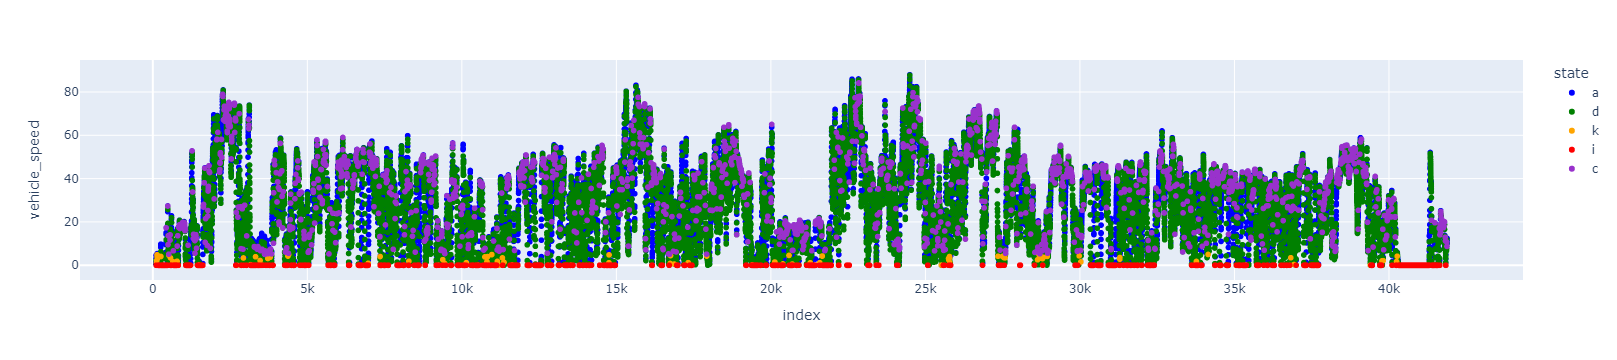

In [218]:
import plotly.express as px
fig = px.scatter(plot_data, x='index', y="vehicle_speed", color="state",
                 color_discrete_sequence = ["blue","green","orange","red","darkorchid"]
                 )
fig.show()

### 2.4 Classify the micro-fragments according to the Road type

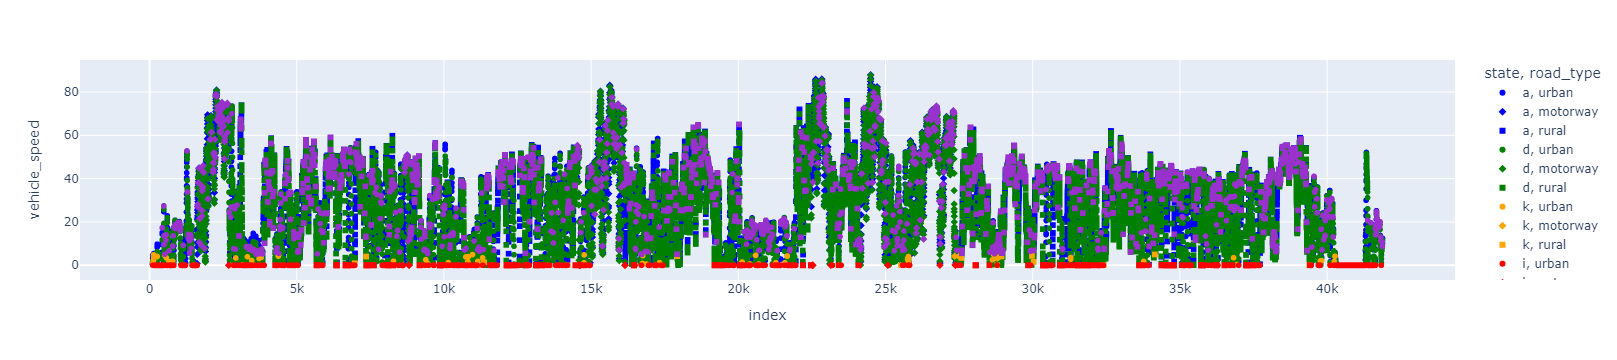

In [219]:
fig = px.scatter(plot_data, x='index', y="vehicle_speed", color="state",
                 color_discrete_sequence = ["blue","green","orange","red","darkorchid"],symbol='road_type')
fig.show()

## 3. Markov-chain 

Markov chain is a mathematical theory used to model a random process with Markov property. Markov property
can be expressed as that the next state depends entirely on the current state, and not any preceding or
following states.

    As to driving process, the velocity of vehicle at the next moment is only relevant to the current vehicle velocity.
    Therefore, the velocity changes of vehicles can be modelled as a Markov random process. Transition probability can
    be extracted from velocity data and used to describe the characteristics of velocity changes in driving process.

### 3.1 Making driving states (15) using velocity range


bins=[-1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,100]

In [220]:
bins=[-1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,100]


#full_data =pd.DataFrame()
full_data['speed']= full_data.vehicle_speed

# full_data.columns=['speed']
# full_data['bins']= pd.cut(full_data.speed,bins)

# full_data['counts']= 1

full_data.reset_index(inplace=True, drop =True)

In [221]:
full_data['state_vel']=np.nan
full_data.at[full_data.loc[np.where((full_data['speed']>-1) & (full_data['speed']<=5))].index, 'state_vel'] = 0
full_data.at[full_data.loc[np.where((full_data['speed']>5) & (full_data['speed']<=10))].index, 'state_vel'] = 1
full_data.at[full_data.loc[np.where((full_data['speed']>10) & (full_data['speed']<=15))].index, 'state_vel'] = 2
full_data.at[full_data.loc[np.where((full_data['speed']>15) & (full_data['speed']<=20))].index, 'state_vel'] = 3
full_data.at[full_data.loc[np.where((full_data['speed']>20) & (full_data['speed']<=25))].index, 'state_vel'] = 4
full_data.at[full_data.loc[np.where((full_data['speed']>25) & (full_data['speed']<=30))].index, 'state_vel'] = 5
full_data.at[full_data.loc[np.where((full_data['speed']>30) & (full_data['speed']<=35))].index, 'state_vel'] = 6
full_data.at[full_data.loc[np.where((full_data['speed']>35) & (full_data['speed']<=40))].index, 'state_vel'] = 7
full_data.at[full_data.loc[np.where((full_data['speed']>40) & (full_data['speed']<=45))].index, 'state_vel'] = 8
full_data.at[full_data.loc[np.where((full_data['speed']>45) & (full_data['speed']<=50))].index, 'state_vel'] = 9
full_data.at[full_data.loc[np.where((full_data['speed']>50) & (full_data['speed']<=55))].index, 'state_vel'] = 10
full_data.at[full_data.loc[np.where((full_data['speed']>55) & (full_data['speed']<=60))].index, 'state_vel'] = 11
full_data.at[full_data.loc[np.where((full_data['speed']>60) & (full_data['speed']<=65))].index, 'state_vel'] = 12
full_data.at[full_data.loc[np.where((full_data['speed']>65) & (full_data['speed']<=70))].index, 'state_vel'] = 13
full_data.at[full_data.loc[np.where((full_data['speed']>70) & (full_data['speed']<=75))].index, 'state_vel'] = 14

full_data.reset_index(inplace=True, drop =True)


In [222]:
urban_full=full_data[full_data['road_type']=='urban']
rural_full=full_data[full_data['road_type']=='rural']
motorway_full=full_data[full_data['road_type']=='motorway']


full_data['index'] = full_data.index
full_data.reset_index(inplace=True, drop =True)

### 3.2 Establish TPM for each road types

#### URBAN

In [223]:
transitions_u = pd.Series(urban_full['state_vel'])

transitions_u = [round(x) for x in transitions_u]

In [224]:
def transition__atrix(transitions):
    n = 1+max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

#test:


m = transition__atrix(transitions_u)
#for row in m: print(' '.join('{0:.3f}'.format(x) for x in row))

In [225]:
transition_matrix_u_ = np.array(m)
pd.options.display.float_format = '{:,.3f}'.format
transition_matrix_u = pd.DataFrame(transition_matrix_u_, columns=['v0', 'v1', 'v2','v3','v4','v5','v6','v7','v8','v9','v10'
                                                                 ,'v11','v12','v13','v14'])
transition_matrix_u.index = transition_matrix_u.columns
transition_matrix_u

v0    v1    v2    v3    v4    v5    v6    v7    v8    v9   v10   v11  \
v0  0.959 0.039 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
v1  0.170 0.687 0.141 0.002 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
v2  0.009 0.160 0.690 0.138 0.003 0.001 0.000 0.000 0.000 0.000 0.000 0.000   
v3  0.000 0.007 0.111 0.780 0.101 0.001 0.000 0.000 0.000 0.000 0.000 0.000   
v4  0.001 0.000 0.007 0.165 0.683 0.139 0.005 0.000 0.000 0.000 0.000 0.000   
v5  0.000 0.000 0.000 0.011 0.172 0.664 0.153 0.000 0.000 0.000 0.000 0.000   
v6  0.003 0.000 0.000 0.000 0.008 0.194 0.665 0.129 0.002 0.000 0.000 0.000   
v7  0.002 0.000 0.000 0.000 0.000 0.007 0.171 0.688 0.132 0.000 0.000 0.000   
v8  0.000 0.000 0.000 0.000 0.000 0.000 0.017 0.140 0.779 0.064 0.000 0.000   
v9  0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.029 0.146 0.730 0.095 0.000   
v10 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.012 0.155 0.786 0.048   
v11 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.045 0.136 0.727   
v12 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.333   
v13 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
v14 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   

      v12   v13   v14  
v0  0.000 0.000 0.000  
v1  0.000 0.000 0.000  
v2  0.000 0.000 0.000  
v3  0.000 0.000 0.000  
v4  0.000 0.000 0.000  
v5  0.000 0.000 0.000  
v6  0.000 0.000 0.000  
v7  0.000 0.000 0.000  
v8  0.000 0.000 0.000  
v9  0.000 0.000 0.000  
v10 0.000 0.000 0.000  
v11 0.091 0.000 0.000  
v12 0.500 0.167 0.000  
v13 0.200 0.400 0.400  
v14 0.000 0.133 0.867

In [226]:
import numpy as np
 
class MarkovChain(object):
    def __init__(self, transition_matrix, states):
        """
        Initialize the MarkovChain instance.
 
        Parameters
        ----------
        transition_matrix: 2-D array
            A 2-D array representing the probabilities of change of 
            state in the Markov Chain.
 
        states: 1-D array 
            An array representing the states of the Markov Chain. It
            needs to be in the same order as transition_matrix.
        """
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.states = states
        self.index_dict = {self.states[index]: index for index in 
                           range(len(self.states))}
        self.state_dict = {index: self.states[index] for index in
                           range(len(self.states))}
 
    def next_state(self, current_state):
        """
        Returns the state of the random variable at the next time 
        instance.
 
        Parameters
        ----------
        current_state: str
            The current state of the system.
        """
        return np.random.choice(
         self.states, 
         p=self.transition_matrix[self.index_dict[current_state], :]
        )
 
    def generate_states(self, current_state, no=10):
        """
        Generates the next states of the system.
 
        Parameters
        ----------
        current_state: str
            The state of the current random variable.
 
        no: int
            The number of future states to generate.
        """
        future_states = []
        for i in range(no):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
        return future_states

In [227]:
#transition_matrix_u

In [228]:
chain = MarkovChain(transition_matrix=transition_matrix_u,states=['v0', 'v1', 'v2','v3','v4','v5','v6','v7','v8','v9','v10'
                                                                 ,'v11','v12','v13','v14'])

In [229]:
gen_seq = np.array(chain.generate_states(current_state='v0', no=50000))


In [230]:
full_data['state_v']=np.nan
full_data.at[full_data.loc[np.where((full_data['speed']>-1) & (full_data['speed']<=5))].index, 'state_v'] = 'v0'
full_data.at[full_data.loc[np.where((full_data['speed']>5) & (full_data['speed']<=10))].index, 'state_v'] = 'v1'
full_data.at[full_data.loc[np.where((full_data['speed']>10) & (full_data['speed']<=15))].index, 'state_v'] = 'v2'
full_data.at[full_data.loc[np.where((full_data['speed']>15) & (full_data['speed']<=20))].index, 'state_v'] = 'v3'
full_data.at[full_data.loc[np.where((full_data['speed']>20) & (full_data['speed']<=25))].index, 'state_v'] = 'v4'
full_data.at[full_data.loc[np.where((full_data['speed']>25) & (full_data['speed']<=30))].index, 'state_v'] = 'v5'
full_data.at[full_data.loc[np.where((full_data['speed']>30) & (full_data['speed']<=35))].index, 'state_v'] = 'v6'
full_data.at[full_data.loc[np.where((full_data['speed']>35) & (full_data['speed']<=40))].index, 'state_v'] = 'v7'
full_data.at[full_data.loc[np.where((full_data['speed']>40) & (full_data['speed']<=45))].index, 'state_v'] = 'v8'
full_data.at[full_data.loc[np.where((full_data['speed']>45) & (full_data['speed']<=50))].index, 'state_v'] = 'v9'
full_data.at[full_data.loc[np.where((full_data['speed']>50) & (full_data['speed']<=55))].index, 'state_v'] = 'v10'
full_data.at[full_data.loc[np.where((full_data['speed']>55) & (full_data['speed']<=60))].index, 'state_v'] ='v11'
full_data.at[full_data.loc[np.where((full_data['speed']>60) & (full_data['speed']<=65))].index, 'state_v'] = 'v12'
full_data.at[full_data.loc[np.where((full_data['speed']>65) & (full_data['speed']<=70))].index, 'state_v'] = 'v13'
full_data.at[full_data.loc[np.where((full_data['speed']>70) & (full_data['speed']<=100))].index, 'state_v'] = 'v14'

full_data.reset_index(inplace=True, drop =True)


urban_full=full_data[full_data['road_type']=='urban']
rural_full=full_data[full_data['road_type']=='rural']
motorway_full=full_data[full_data['road_type']=='motorway']


original_seq_u = urban_full['state_v']
original_seq_r = rural_full['state_v']
original_seq_m = motorway_full['state_v']
original_seq_f = full_data['state_v']

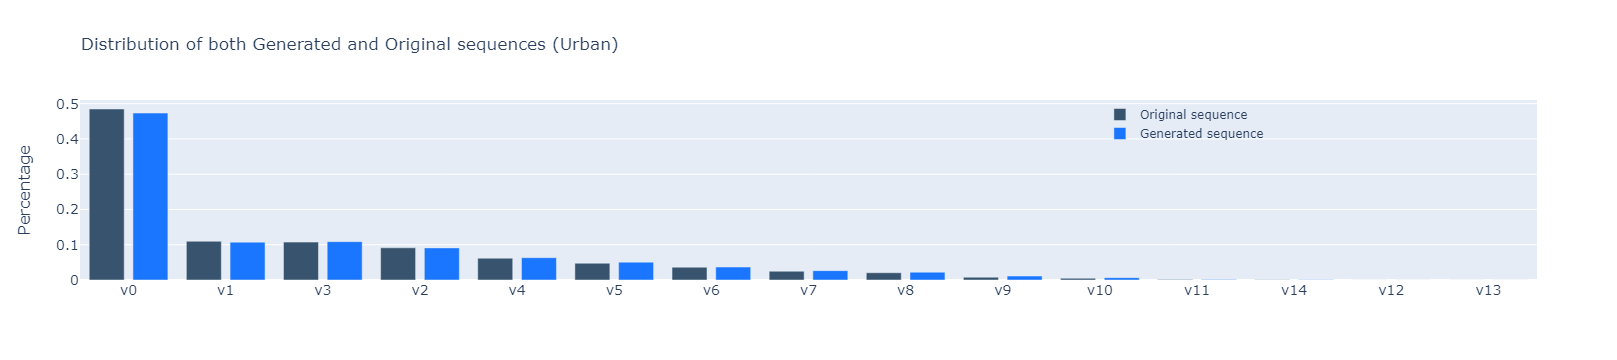

In [231]:
import plotly.graph_objects as go
gen_u = pd.Series(gen_seq).sort_values()
org_u = pd.Series(original_seq_u).sort_values()
index=org_u.value_counts().index.tolist()
index1=gen_u.value_counts().index.tolist()
# gw = g.value_counts().tolist()
# gow = g_o.value_counts().tolist()
gw = np.divide(gen_u.value_counts().tolist(),len(gen_u))
gow = np.divide(org_u.value_counts().tolist(),len(org_u))

fig = go.Figure()
fig.add_trace(go.Bar(x=index,
                y=gow,
                name='Original sequence',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=index1,
                y=gw,
                name='Generated sequence',
                marker_color='rgb(26, 118, 255)'
                ))

fig.update_layout(
    title='Distribution of both Generated and Original sequences (Urban)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Percentage',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=.7,
        y=1.0,
        bgcolor='rgba(255, 25, 25, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.1, # gap between bars of adjacent location coordinates.
    bargroupgap=0.2 # gap between bars of the same location coordinate.
)
fig.show()

In [232]:
mse = metrics.mean_squared_error(gow*100,gw*100)
print('RMSE for Urban : ',np.sqrt(mse))

RMSE for Urban :  0.3320059466400929


### Driving characteristic parameters for Urban (Original)

-------------------------------------------------------
Urban Proportion in the Data :  41.418747910797
-------------------------------------------------------
Percentage(%) of Driving state 'i' : 33.61964604830806
Percentage(%) of Driving state 'a' : 31.08318441229031
Percentage(%) of Driving state 'd' : 30.633538940450798
Percentage(%) of Driving state 'c' : 3.868103994927077
Percentage(%) of Driving state 'k' : 0.7955266040237505
-------------------------------------------------------
Minimum value of speed :  0.0
Maximum value of speed :  73.51
Average value of speed :  10.602215368651871
-------------------------------------------------------
RMS of Acceleration :  1.6759615424335166
-------------------------------------------------------


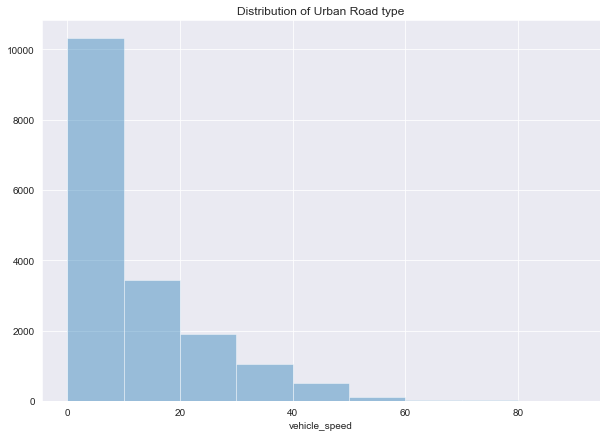

In [233]:
print('-------------------------------------------------------')
print('Urban Proportion in the Data : ', len(urban_full)/len(full_data)*100)
print('-------------------------------------------------------')
print("Percentage(%) of Driving state 'i' :", len(urban_full[urban_full['state'] =='i'])/len(urban_full)*100)
print("Percentage(%) of Driving state 'a' :", len(urban_full[urban_full['state'] =='a'])/len(urban_full)*100)
print("Percentage(%) of Driving state 'd' :", len(urban_full[urban_full['state'] =='d'])/len(urban_full)*100)
print("Percentage(%) of Driving state 'c' :", len(urban_full[urban_full['state'] =='c'])/len(urban_full)*100)
print("Percentage(%) of Driving state 'k' :", len(urban_full[urban_full['state'] =='k'])/len(urban_full)*100)
print('-------------------------------------------------------')
print('Minimum value of speed : ', urban_full['vehicle_speed'].min())
print('Maximum value of speed : ', urban_full['vehicle_speed'].max())
print('Average value of speed : ', urban_full['vehicle_speed'].mean())
print('-------------------------------------------------------')
print('RMS of Acceleration : ' ,np.sqrt(np.mean(urban_full['accel'].dropna()**2)))
print('-------------------------------------------------------')
plt.figure(figsize=(10,7))
sns.distplot(urban_full['vehicle_speed'].dropna(),bins=[0,10,20,30,40,50,60,70,80,90], kde=False)
plt.title("Distribution of Urban Road type")
plt.show()

### Cumulative TPM for urban

In [234]:
#np.set_printoptions(precision=5,suppress=True)
cum_tpm_u = np.cumsum(transition_matrix_u_,axis=1)

pd.options.display.float_format = '{:,.3f}'.format
cum_tpm1 = pd.DataFrame(cum_tpm_u, columns=['v0', 'v1', 'v2','v3','v4','v5','v6','v7','v8','v9','v10'
                                                                 ,'v11','v12','v13','v14'])
cum_tpm1.index = cum_tpm1.columns
cum_tpm1

v0    v1    v2    v3    v4    v5    v6    v7    v8    v9   v10   v11  \
v0  0.959 0.998 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
v1  0.170 0.857 0.998 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
v2  0.009 0.169 0.858 0.997 0.999 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
v3  0.000 0.007 0.118 0.898 0.999 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
v4  0.001 0.001 0.008 0.173 0.856 0.995 1.000 1.000 1.000 1.000 1.000 1.000   
v5  0.000 0.000 0.000 0.011 0.183 0.847 1.000 1.000 1.000 1.000 1.000 1.000   
v6  0.003 0.003 0.003 0.003 0.011 0.205 0.870 0.998 1.000 1.000 1.000 1.000   
v7  0.002 0.002 0.002 0.002 0.002 0.009 0.181 0.868 1.000 1.000 1.000 1.000   
v8  0.000 0.000 0.000 0.000 0.000 0.000 0.017 0.157 0.936 1.000 1.000 1.000   
v9  0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.029 0.175 0.905 1.000 1.000   
v10 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.012 0.167 0.952 1.000   
v11 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.045 0.182 0.909   
v12 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.333   
v13 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
v14 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   

      v12   v13   v14  
v0  1.000 1.000 1.000  
v1  1.000 1.000 1.000  
v2  1.000 1.000 1.000  
v3  1.000 1.000 1.000  
v4  1.000 1.000 1.000  
v5  1.000 1.000 1.000  
v6  1.000 1.000 1.000  
v7  1.000 1.000 1.000  
v8  1.000 1.000 1.000  
v9  1.000 1.000 1.000  
v10 1.000 1.000 1.000  
v11 1.000 1.000 1.000  
v12 0.833 1.000 1.000  
v13 0.200 0.600 1.000  
v14 0.000 0.133 1.000

In [348]:
def drive_cycle(road_type, full_data,cum_tpm):
    curr_cycle_vel = [0]
    curr_cycle_acc = [0]
    curr_cycle_mdf = ['i']
    c = 0

    def appen_vel(ch_in_vel):
        curr_cycle_vel.append(np.asscalar(ch_in_vel)) 
        return curr_cycle_vel[c+1]

    def appen_mdf(ch_mdf):
        curr_cycle_mdf.append(np.asscalar(ch_mdf)) 
        return curr_cycle_mdf[c+1]

    def appen_acc(ch_in_acc):
        curr_cycle_acc.append(np.asscalar(ch_in_acc)) 
        return curr_cycle_acc[c+1]

    while len(curr_cycle_vel)< round(1200*len(road_type)/len(full_data)):


        i = np.asscalar(np.array(random.sample(np.arange(0,len(cum_tpm)).tolist(),1)))
        rr = np.random.uniform()
        int_st = bisect.bisect_left(cum_tpm[i,],rr)

        mdf_with_speed_ch = full_data[full_data['state_vel']==int_st]
        mdf_with_speed_ch = mdf_with_speed_ch[['state','vehicle_speed','accel']].sample()

        ch_in_vel = mdf_with_speed_ch['vehicle_speed']
        ch_in_acc = mdf_with_speed_ch['accel']
        #print(ch_in_vel)
        ch_mdf = mdf_with_speed_ch['state']
        #print(curr_cycle_vel)   

       #Compute difference
        spfic_val = 3.5

        delta = abs(np.subtract(np.asscalar(ch_in_vel) , curr_cycle_vel[c]))
        #print(delta)
        if delta < spfic_val:
            appen_vel(ch_in_vel)
            appen_mdf(ch_mdf)
            appen_acc(ch_in_acc)
            c +=1
    
    gdc = pd.DataFrame(columns=['index', 'velocity','mdf','acc'])
    gdc['velocity'] = curr_cycle_vel
    gdc['mdf'] = curr_cycle_mdf
    gdc['acc'] = curr_cycle_acc
    gdc['index'] = gdc.index
    
    prop_mdf_i = round(len(gdc[gdc.mdf=='i'])/len(gdc)*100,2)
    prop_mdf_a = round(len(gdc[gdc.mdf=='a'])/len(gdc)*100,2)
    prop_mdf_d = round(len(gdc[gdc.mdf=='d'])/len(gdc)*100,2)
    prop_mdf_c = round(len(gdc[gdc.mdf=='c'])/len(gdc)*100,2)
    prop_mdf_k = round(len(gdc[gdc.mdf=='k'])/len(gdc)*100,2)
    prop_org_mdf_i = round(len(full_data[full_data.state=='i'])/len(full_data)*100,2)
    prop_org_mdf_a = round(len(full_data[full_data.state=='a'])/len(full_data)*100,2)
    prop_org_mdf_d = round(len(full_data[full_data.state=='d'])/len(full_data)*100,2)
    prop_org_mdf_c = round(len(full_data[full_data.state=='c'])/len(full_data)*100,2)
    prop_org_mdf_k = round(len(full_data[full_data.state=='k'])/len(full_data)*100,2)
    
    df_g = gdc[['velocity','acc']].describe().reset_index()
    df_r = full_data[['vehicle_speed','accel']].describe().reset_index()
    std_gen_v = np.asscalar(df_g[2:3]['velocity'])
    max_gen_v = np.asscalar(df_g[7:8]['velocity'])
    min_gen_v = np.asscalar(df_g[3:4]['velocity'])
    mean_gen_v = np.asscalar(df_g[1:2]['velocity'])

    std_gen_a = np.asscalar(df_g[2:3]['acc'])
    max_gen_a = np.asscalar(df_g[7:8]['acc'])
    min_gen_a = np.asscalar(df_g[3:4]['acc'])
    mean_gen_a = np.asscalar(df_g[1:2]['acc'])
    
    std_org_v = np.asscalar(df_r[2:3]['vehicle_speed'])
    max_org_v = np.asscalar(df_r[7:8]['vehicle_speed'])
    min_org_v = np.asscalar(df_r[3:4]['vehicle_speed'])
    mean_org_v = np.asscalar(df_r[1:2]['vehicle_speed'])

    std_org_a = np.asscalar(df_r[2:3]['accel'])
    max_org_a = np.asscalar(df_r[7:8]['accel'])
    min_org_a = np.asscalar(df_r[3:4]['accel'])
    mean_org_a = np.asscalar(df_r[1:2]['accel'])
    
    Parameters = ['Proportion of Idel (%)','Proportion of Acceleration (%)','Proportion of Deceleration (%)',
              'Proportion of Cruise (%)','Proportion of Creep (%)',
             'STD of velocity','Maximum of velocity ( km / h )','Minimum of velocity ( km / h )',
             'Mean of velocity ( km / h )','STD of acceleration','Maximum of acceleration ( m/ s2 )',
              'Minimum of acceleration ( m/ s2 )','Mean of acceleration ( m/ s2 )']

    val = pd.DataFrame(columns = ['Real-world data', 'Generated drive cycle'],index=Parameters)
    val['Real-world data'] = [ prop_org_mdf_i,prop_org_mdf_a,  prop_org_mdf_d,prop_org_mdf_c,prop_org_mdf_k,std_org_v, max_org_v,
                             min_org_v, mean_org_v, std_org_a, max_org_a, min_org_a, mean_org_a ]
    val['Generated drive cycle'] = [ prop_mdf_i, prop_mdf_a, prop_mdf_d, prop_mdf_c, prop_mdf_k,
                                   std_gen_v, max_gen_v, min_gen_v, mean_gen_v, std_gen_a, max_gen_a, min_gen_a,
                                   mean_gen_a]
    
    real_world_para  = val['Real-world data'].tolist()
    gen_para = val['Generated drive cycle'].tolist()
    real_world_para=[0.01 if x==0.0 else x for x in real_world_para]
    
    n = len(real_world_para) 
    for i in range (0,n):  
        s = np.sum((((gen_para[i] - real_world_para[i])**2) /  real_world_para[i])) 
    RMSRE = (s/n)*100
    print("RMSRE : ", RMSRE)
    
    return gdc 

## Monte carlo simulation(N times) with corresponding RMSRE:

In [236]:
for i in range(20):
    print(i)
    exec(f'gdc_u_{i} = drive_cycle(urban_full, full_data,cum_tpm_u)')

0


C:\Users\u23e00\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\type_check.py:547: FutureWarning:

`item` has been deprecated and will be removed in a future version



RMSRE :  1.1017784669830266
1
RMSRE :  11.528900439514302
2
RMSRE :  7.501958587225088
3
RMSRE :  5.976668514876841
4
RMSRE :  0.23528546174537746
5
RMSRE :  0.3782364528382464
6
RMSRE :  28.501256889130584
7
RMSRE :  15.79434756312297
8
RMSRE :  0.022198777812004206
9
RMSRE :  2.7574480337000407
10
RMSRE :  27.835372119185763
11
RMSRE :  0.6391591275707931
12
RMSRE :  14.991601382870515
13
RMSRE :  1.5920224801270935
14
RMSRE :  0.6237246320865095
15
RMSRE :  24.995997873273033
16
RMSRE :  0.1363837808246666
17
RMSRE :  33.42599822610237
18
RMSRE :  6.586688848109927
19
RMSRE :  13.30137920345884


### Generated Drive cycle for urban

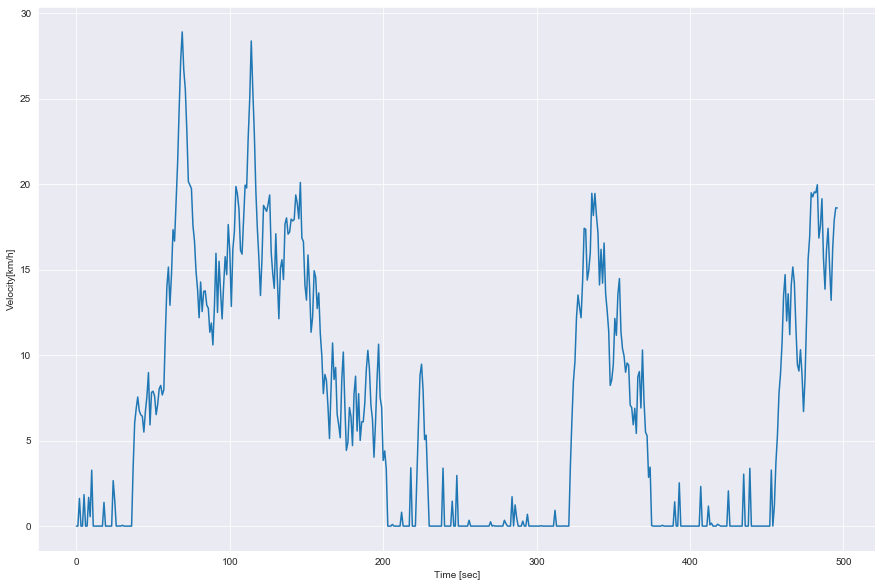

In [278]:
plt.figure(figsize=(15,10))
plt.plot(gdc_u_16["velocity"])
#plt.plot(gdc["4cc"])
plt.grid(True)
plt.xlabel('Time [sec]') 
plt.ylabel('Velocity[km/h]')
plt.show()

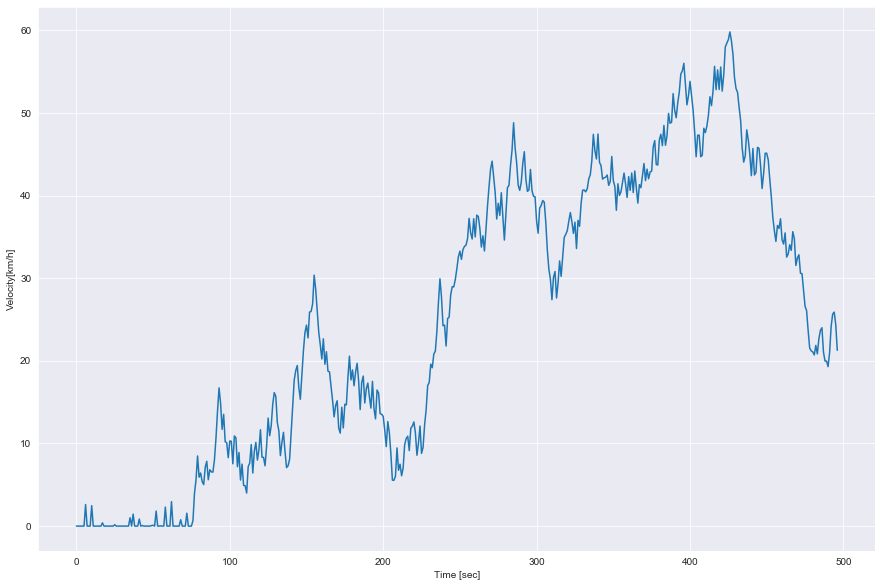

In [398]:
plt.figure(figsize=(15,10))
plt.plot(gdc_u_8["velocity"])
#plt.plot(gdc["4cc"])
plt.grid(True)
plt.xlabel('Time [sec]') 
plt.ylabel('Velocity[km/h]')
plt.show()

### Driving characteristic parameters for Urban (Generated and Original)

----------------------------------------------------------------------------
                                   Real-world data  Generated drive cycle
Proportion of Idel (%)                      33.620                 36.820
Proportion of Acceleration (%)              31.080                 29.980
Proportion of Deceleration (%)              30.630                 28.770
Proportion of Cruise (%)                     3.870                  4.020
Proportion of Creep (%)                      0.800                  0.400
STD of velocity                             12.677                  7.363
Maximum of velocity ( km / h )              73.510                 28.910
Minimum of velocity ( km / h )               0.000                  0.000
Mean of velocity ( km / h )                 10.602                  6.910
STD of acceleration                          1.676                  1.746
Maximum of acceleration ( m/ s2 )            9.000                  6.570
Minimum of acceleration ( m/ s2 )  

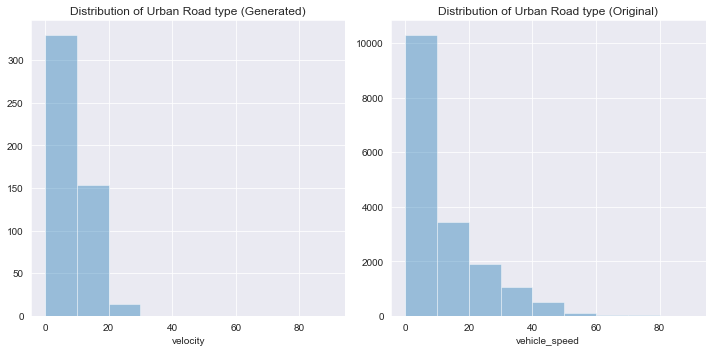

In [350]:
    prop_mdf_i = round(len(gdc_u_16[gdc_u_16.mdf=='i'])/len(gdc_u_16)*100,2)
    prop_mdf_a = round(len(gdc_u_16[gdc_u_16.mdf=='a'])/len(gdc_u_16)*100,2)
    prop_mdf_d = round(len(gdc_u_16[gdc_u_16.mdf=='d'])/len(gdc_u_16)*100,2)
    prop_mdf_c = round(len(gdc_u_16[gdc_u_16.mdf=='c'])/len(gdc_u_16)*100,2)
    prop_mdf_k = round(len(gdc_u_16[gdc_u_16.mdf=='k'])/len(gdc_u_16)*100,2)
    prop_org_mdf_i = round(len(urban_full[urban_full.state=='i'])/len(urban_full)*100,2)
    prop_org_mdf_a = round(len(urban_full[urban_full.state=='a'])/len(urban_full)*100,2)
    prop_org_mdf_d = round(len(urban_full[urban_full.state=='d'])/len(urban_full)*100,2)
    prop_org_mdf_c = round(len(urban_full[urban_full.state=='c'])/len(urban_full)*100,2)
    prop_org_mdf_k = round(len(urban_full[urban_full.state=='k'])/len(urban_full)*100,2)
    
    df_g = gdc_u_16[['velocity','acc']].describe().reset_index()
    df_r = urban_full[['vehicle_speed','accel']].describe().reset_index()
    std_gen_v = np.asscalar(df_g[2:3]['velocity'])
    max_gen_v = np.asscalar(df_g[7:8]['velocity'])
    min_gen_v = np.asscalar(df_g[3:4]['velocity'])
    mean_gen_v = np.asscalar(df_g[1:2]['velocity'])

    std_gen_a = np.asscalar(df_g[2:3]['acc'])
    max_gen_a = np.asscalar(df_g[7:8]['acc'])
    min_gen_a = np.asscalar(df_g[3:4]['acc'])
    mean_gen_a = np.asscalar(df_g[1:2]['acc'])
    
    std_org_v = np.asscalar(df_r[2:3]['vehicle_speed'])
    max_org_v = np.asscalar(df_r[7:8]['vehicle_speed'])
    min_org_v = np.asscalar(df_r[3:4]['vehicle_speed'])
    mean_org_v = np.asscalar(df_r[1:2]['vehicle_speed'])

    std_org_a = np.asscalar(df_r[2:3]['accel'])
    max_org_a = np.asscalar(df_r[7:8]['accel'])
    min_org_a = np.asscalar(df_r[3:4]['accel'])
    mean_org_a = np.asscalar(df_r[1:2]['accel'])
    
    Parameters = ['Proportion of Idel (%)','Proportion of Acceleration (%)','Proportion of Deceleration (%)',
              'Proportion of Cruise (%)','Proportion of Creep (%)',
             'STD of velocity','Maximum of velocity ( km / h )','Minimum of velocity ( km / h )',
             'Mean of velocity ( km / h )','STD of acceleration','Maximum of acceleration ( m/ s2 )',
              'Minimum of acceleration ( m/ s2 )','Mean of acceleration ( m/ s2 )']

    val = pd.DataFrame(columns = ['Real-world data', 'Generated drive cycle'],index=Parameters)
    val['Real-world data'] = [ prop_org_mdf_i,prop_org_mdf_a,  prop_org_mdf_d,prop_org_mdf_c,prop_org_mdf_k,std_org_v, max_org_v,
                             min_org_v, mean_org_v, std_org_a, max_org_a, min_org_a, mean_org_a ]
    val['Generated drive cycle'] = [ prop_mdf_i, prop_mdf_a, prop_mdf_d, prop_mdf_c, prop_mdf_k,
                                   std_gen_v, max_gen_v, min_gen_v, mean_gen_v, std_gen_a, max_gen_a, min_gen_a,
                                   mean_gen_a]
    
print('----------------------------------------------------------------------------')
    print(val)
    


f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.distplot(gdc_u_16['velocity'].dropna(),bins=[0,10,20,30,40,50,60,70,80,90], kde=False, ax=axes[0])
axes[0].set_title("Distribution of Urban Road type (Generated)")

print('----------------------------------------------------------------------------')
sns.distplot(urban_full['vehicle_speed'].dropna(),bins=[0,10,20,30,40,50,60,70,80,90], kde=False, ax=axes[1])
axes[1].set_title("Distribution of Urban Road type (Original)")


plt.tight_layout()

#### RURAL

In [239]:
transitions_r = pd.Series(rural_full['state_vel']).dropna()
transitions_r = [round(x) for x in transitions_r]


In [240]:
def transition__atrix(transitions):
    n = 1+max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

#test:


m_r = transition__atrix(transitions_r)
#for row in m: print(' '.join('{0:.3f}'.format(x) for x in row))

In [241]:
transition_matrix_r_ = np.array(m_r)

pd.options.display.float_format = '{:,.3f}'.format
transition_matrix_r = pd.DataFrame(transition_matrix_r_, columns=['v0', 'v1', 'v2','v3','v4','v5','v6','v7','v8','v9','v10'
                                                                 ,'v11','v12','v13','v14'])
transition_matrix_r.index = transition_matrix_r.columns
transition_matrix_r

v0    v1    v2    v3    v4    v5    v6    v7    v8    v9   v10   v11  \
v0  0.936 0.057 0.005 0.000 0.000 0.001 0.000 0.000 0.000 0.001 0.000 0.000   
v1  0.124 0.682 0.190 0.004 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
v2  0.006 0.148 0.662 0.184 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
v3  0.000 0.008 0.166 0.620 0.196 0.009 0.000 0.000 0.000 0.000 0.000 0.000   
v4  0.000 0.001 0.010 0.170 0.607 0.210 0.003 0.000 0.000 0.000 0.000 0.000   
v5  0.000 0.000 0.001 0.007 0.126 0.703 0.162 0.001 0.000 0.000 0.000 0.000   
v6  0.000 0.000 0.001 0.001 0.003 0.129 0.727 0.140 0.001 0.000 0.000 0.000   
v7  0.000 0.000 0.000 0.000 0.000 0.004 0.086 0.815 0.095 0.000 0.000 0.000   
v8  0.000 0.000 0.000 0.000 0.000 0.000 0.005 0.069 0.859 0.066 0.000 0.000   
v9  0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.004 0.090 0.853 0.051 0.000   
v10 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.001 0.006 0.108 0.824 0.058   
v11 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.013 0.172 0.735   
v12 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.203   
v13 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.030   
v14 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   

      v12   v13   v14  
v0  0.000 0.000 0.000  
v1  0.000 0.000 0.000  
v2  0.000 0.000 0.000  
v3  0.000 0.000 0.000  
v4  0.000 0.000 0.000  
v5  0.000 0.000 0.000  
v6  0.000 0.000 0.000  
v7  0.000 0.000 0.000  
v8  0.000 0.000 0.000  
v9  0.000 0.000 0.000  
v10 0.001 0.000 0.000  
v11 0.079 0.000 0.000  
v12 0.729 0.068 0.000  
v13 0.182 0.636 0.152  
v14 0.050 0.200 0.750

In [242]:
import numpy as np
 
class MarkovChain(object):
    def __init__(self, transition_matrix, states):
        """
        Initialize the MarkovChain instance.
 
        Parameters
        ----------
        transition_matrix: 2-D array
            A 2-D array representing the probabilities of change of 
            state in the Markov Chain.
 
        states: 1-D array 
            An array representing the states of the Markov Chain. It
            needs to be in the same order as transition_matrix.
        """
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.states = states
        self.index_dict = {self.states[index]: index for index in 
                           range(len(self.states))}
        self.state_dict = {index: self.states[index] for index in
                           range(len(self.states))}
 
    def next_state(self, current_state):
        """
        Returns the state of the random variable at the next time 
        instance.
 
        Parameters
        ----------
        current_state: str
            The current state of the system.
        """
        return np.random.choice(
         self.states, 
         p=self.transition_matrix[self.index_dict[current_state], :]
        )
 
    def generate_states(self, current_state, no=10):
        """
        Generates the next states of the system.
 
        Parameters
        ----------
        current_state: str
            The state of the current random variable.
 
        no: int
            The number of future states to generate.
        """
        future_states = []
        for i in range(no):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
        return future_states

In [243]:
chain = MarkovChain(transition_matrix_r, states=['v0', 'v1', 'v2','v3','v4','v5','v6','v7','v8','v9','v10'
                                                                 ,'v11','v12','v13','v14'])

In [244]:
gen_seq_r = np.array(chain.generate_states(current_state='v0', no=50000))


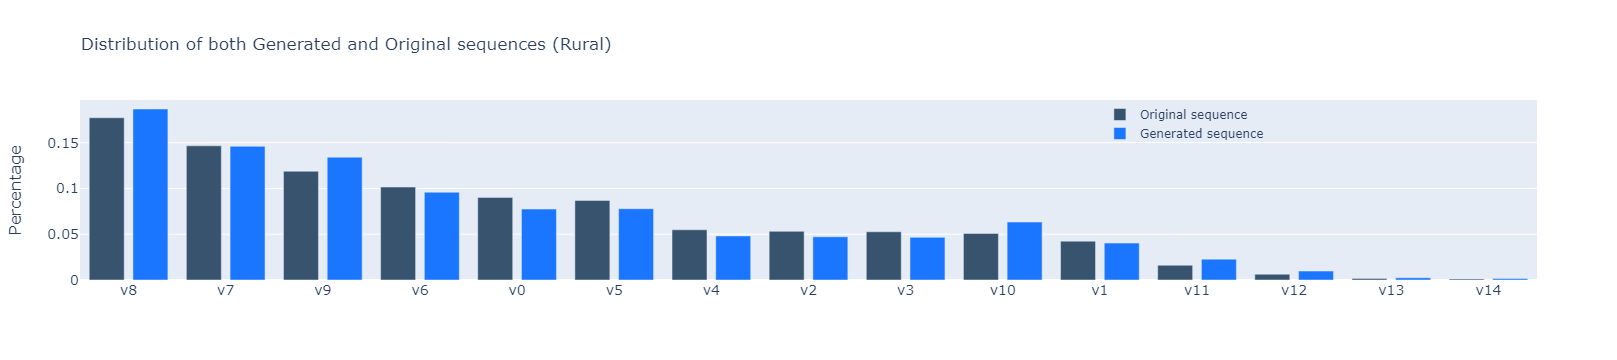

In [245]:
import plotly.graph_objects as go
gen_r = pd.Series(gen_seq_r).sort_values()
org_r = pd.Series(original_seq_r).sort_values()

index=org_r.value_counts().index.tolist()
index1=gen_r.value_counts().index.tolist()
# gw = g.value_counts().tolist()
# gow = g_o.value_counts().tolist()
gw = np.divide(gen_r.value_counts().tolist(),len(gen_r))
gow = np.divide(org_r.value_counts().tolist(),len(org_r))

fig = go.Figure()
fig.add_trace(go.Bar(x=index,
                y=gow,
                name='Original sequence',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=index1,
                y=gw,
                name='Generated sequence',
                marker_color='rgb(26, 118, 255)'
                ))

fig.update_layout(
    title='Distribution of both Generated and Original sequences (Rural)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Percentage',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=.7,
        y=1.0,
        bgcolor='rgba(255, 25, 25, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.1, # gap between bars of adjacent location coordinates.
    bargroupgap=0.2 # gap between bars of the same location coordinate.
)
fig.show()

In [246]:
mse = metrics.mean_squared_error(gow*100,gw*100)
print('RMSE for Rural : ',np.sqrt(mse))

RMSE for Rural :  0.7333934651971312


### Driving characteristic parameters for Rural (Original)

-------------------------------------------------------
rural Proportion in the Data :  44.65880330452222
-------------------------------------------------------
Percentage(%) of Driving state 'i' : 6.137724550898203
Percentage(%) of Driving state 'a' : 45.56244653550043
Percentage(%) of Driving state 'd' : 40.33896492728828
Percentage(%) of Driving state 'c' : 7.8699743370402055
Percentage(%) of Driving state 'k' : 0.0908896492728828
-------------------------------------------------------
Minimum value of speed :  0.0
Maximum value of speed :  75.9
Average value of speed :  31.73768071000915
-------------------------------------------------------
RMS of Acceleration :  1.7483151167434465
-------------------------------------------------------


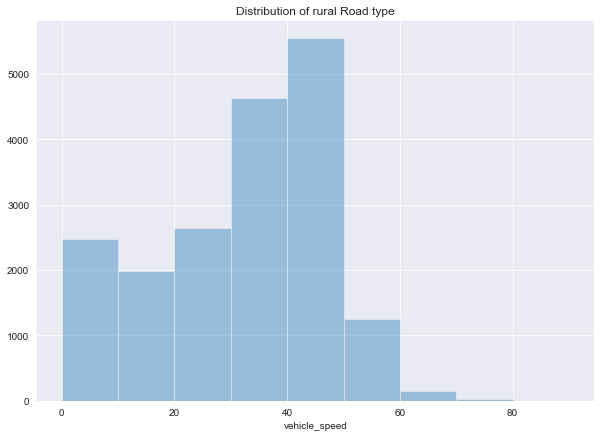

In [247]:
print('-------------------------------------------------------')
print('rural Proportion in the Data : ', len(rural_full)/len(full_data)*100)
print('-------------------------------------------------------')
print("Percentage(%) of Driving state 'i' :", len(rural_full[rural_full['state'] =='i'])/len(rural_full)*100)
print("Percentage(%) of Driving state 'a' :", len(rural_full[rural_full['state'] =='a'])/len(rural_full)*100)
print("Percentage(%) of Driving state 'd' :", len(rural_full[rural_full['state'] =='d'])/len(rural_full)*100)
print("Percentage(%) of Driving state 'c' :", len(rural_full[rural_full['state'] =='c'])/len(rural_full)*100)
print("Percentage(%) of Driving state 'k' :", len(rural_full[rural_full['state'] =='k'])/len(rural_full)*100)
print('-------------------------------------------------------')
print('Minimum value of speed : ', rural_full['vehicle_speed'].min())
print('Maximum value of speed : ', rural_full['vehicle_speed'].max())
print('Average value of speed : ', rural_full['vehicle_speed'].mean())
print('-------------------------------------------------------')
print('RMS of Acceleration : ' ,np.sqrt(np.mean(rural_full['accel'].dropna()**2)))
print('-------------------------------------------------------')
plt.figure(figsize=(10,7))
sns.distplot(rural_full['vehicle_speed'].dropna(),bins=[0,10,20,30,40,50,60,70,80,90], kde=False)
plt.title("Distribution of rural Road type")
plt.show()

### Cumulative TPM for rural

In [248]:
#np.set_printoptions(precision=5,suppress=True)
cum_tpm_r = np.cumsum(transition_matrix_r_,axis=1)

pd.options.display.float_format = '{:,.3f}'.format
cum_tpm1 = pd.DataFrame(cum_tpm_r, columns=['v0', 'v1', 'v2','v3','v4','v5','v6','v7','v8','v9','v10'
                                                                 ,'v11','v12','v13','v14'])
cum_tpm1.index = cum_tpm1.columns
cum_tpm1

v0    v1    v2    v3    v4    v5    v6    v7    v8    v9   v10   v11  \
v0  0.936 0.993 0.998 0.998 0.998 0.999 0.999 0.999 0.999 1.000 1.000 1.000   
v1  0.124 0.806 0.996 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
v2  0.006 0.154 0.816 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
v3  0.000 0.008 0.175 0.795 0.991 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
v4  0.000 0.001 0.011 0.180 0.787 0.997 1.000 1.000 1.000 1.000 1.000 1.000   
v5  0.000 0.000 0.001 0.008 0.134 0.838 0.999 1.000 1.000 1.000 1.000 1.000   
v6  0.000 0.000 0.001 0.001 0.004 0.133 0.859 0.999 1.000 1.000 1.000 1.000   
v7  0.000 0.000 0.000 0.000 0.000 0.004 0.090 0.905 1.000 1.000 1.000 1.000   
v8  0.000 0.000 0.000 0.000 0.000 0.000 0.005 0.074 0.934 1.000 1.000 1.000   
v9  0.001 0.001 0.001 0.001 0.001 0.001 0.002 0.006 0.096 0.949 1.000 1.000   
v10 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.002 0.008 0.117 0.941 0.999   
v11 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.013 0.185 0.921   
v12 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.203   
v13 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.030   
v14 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   

      v12   v13   v14  
v0  1.000 1.000 1.000  
v1  1.000 1.000 1.000  
v2  1.000 1.000 1.000  
v3  1.000 1.000 1.000  
v4  1.000 1.000 1.000  
v5  1.000 1.000 1.000  
v6  1.000 1.000 1.000  
v7  1.000 1.000 1.000  
v8  1.000 1.000 1.000  
v9  1.000 1.000 1.000  
v10 1.000 1.000 1.000  
v11 1.000 1.000 1.000  
v12 0.932 1.000 1.000  
v13 0.212 0.848 1.000  
v14 0.050 0.250 1.000

In [346]:
def drive_cycle_r(road_type, full_data,cum_tpm):
    curr_cycle_vel = [10]
    curr_cycle_acc = [2]
    curr_cycle_mdf = ['a']
    c = 0

    def appen_vel(ch_in_vel):
        curr_cycle_vel.append(np.asscalar(ch_in_vel)) 
        return curr_cycle_vel[c+1]

    def appen_mdf(ch_mdf):
        curr_cycle_mdf.append(np.asscalar(ch_mdf)) 
        return curr_cycle_mdf[c+1]

    def appen_acc(ch_in_acc):
        curr_cycle_acc.append(np.asscalar(ch_in_acc)) 
        return curr_cycle_acc[c+1]

    while len(curr_cycle_vel)< round(1200*len(road_type)/len(full_data)):


        i = np.asscalar(np.array(random.sample(np.arange(0,len(cum_tpm)).tolist(),1)))
        rr = np.random.uniform()
        int_st = bisect.bisect_left(cum_tpm[i,],rr)

        mdf_with_speed_ch = full_data[full_data['state_vel']==int_st]
        mdf_with_speed_ch = mdf_with_speed_ch[['state','vehicle_speed','accel']].sample()

        ch_in_vel = mdf_with_speed_ch['vehicle_speed']
        ch_in_acc = mdf_with_speed_ch['accel']
        #print(ch_in_vel)
        ch_mdf = mdf_with_speed_ch['state']
        #print(curr_cycle_vel)   

       #Compute difference
        spfic_val = 3.7

        delta = abs(np.subtract(np.asscalar(ch_in_vel) , curr_cycle_vel[c]))
        #print(delta)
        if delta < spfic_val:
            appen_vel(ch_in_vel)
            appen_mdf(ch_mdf)
            appen_acc(ch_in_acc)
            c +=1
    
    gdc_r = pd.DataFrame(columns=['index', 'velocity','mdf','acc'])
    gdc_r['velocity'] = curr_cycle_vel
    gdc_r['mdf'] = curr_cycle_mdf
    gdc_r['acc'] = curr_cycle_acc
    gdc_r['index'] = gdc_r.index
    
    prop_mdf_i = round(len(gdc_r[gdc_r.mdf=='i'])/len(gdc_r)*100,2)
    prop_mdf_a = round(len(gdc_r[gdc_r.mdf=='a'])/len(gdc_r)*100,2)
    prop_mdf_d = round(len(gdc_r[gdc_r.mdf=='d'])/len(gdc_r)*100,2)
    prop_mdf_c = round(len(gdc_r[gdc_r.mdf=='c'])/len(gdc_r)*100,2)
    prop_mdf_k = round(len(gdc_r[gdc_r.mdf=='k'])/len(gdc_r)*100,2)
    prop_org_mdf_i = round(len(full_data[full_data.state=='i'])/len(full_data)*100,2)
    prop_org_mdf_a = round(len(full_data[full_data.state=='a'])/len(full_data)*100,2)
    prop_org_mdf_d = round(len(full_data[full_data.state=='d'])/len(full_data)*100,2)
    prop_org_mdf_c = round(len(full_data[full_data.state=='c'])/len(full_data)*100,2)
    prop_org_mdf_k = round(len(full_data[full_data.state=='k'])/len(full_data)*100,2)
    
    df_g = gdc_r[['velocity','acc']].describe().reset_index()
    df_r = full_data[['vehicle_speed','accel']].describe().reset_index()
    std_gen_v = np.asscalar(df_g[2:3]['velocity'])
    max_gen_v = np.asscalar(df_g[7:8]['velocity'])
    min_gen_v = np.asscalar(df_g[3:4]['velocity'])
    mean_gen_v = np.asscalar(df_g[1:2]['velocity'])

    std_gen_a = np.asscalar(df_g[2:3]['acc'])
    max_gen_a = np.asscalar(df_g[7:8]['acc'])
    min_gen_a = np.asscalar(df_g[3:4]['acc'])
    mean_gen_a = np.asscalar(df_g[1:2]['acc'])
    
    std_org_v = np.asscalar(df_r[2:3]['vehicle_speed'])
    max_org_v = np.asscalar(df_r[7:8]['vehicle_speed'])
    min_org_v = np.asscalar(df_r[3:4]['vehicle_speed'])
    mean_org_v = np.asscalar(df_r[1:2]['vehicle_speed'])

    std_org_a = np.asscalar(df_r[2:3]['accel'])
    max_org_a = np.asscalar(df_r[7:8]['accel'])
    min_org_a = np.asscalar(df_r[3:4]['accel'])
    mean_org_a = np.asscalar(df_r[1:2]['accel'])
    
    Parameters = ['Proportion of Idel (%)','Proportion of Acceleration (%)','Proportion of Deceleration (%)',
              'Proportion of Cruise (%)','Proportion of Creep (%)',
             'STD of velocity','Maximum of velocity ( km / h )','Minimum of velocity ( km / h )',
             'Mean of velocity ( km / h )','STD of acceleration','Maximum of acceleration ( m/ s2 )',
              'Minimum of acceleration ( m/ s2 )','Mean of acceleration ( m/ s2 )']

    val = pd.DataFrame(columns = ['Real-world data', 'Generated drive cycle'],index=Parameters)
    val['Real-world data'] = [ prop_org_mdf_i,prop_org_mdf_a,  prop_org_mdf_d,prop_org_mdf_c,prop_org_mdf_k,std_org_v, max_org_v,
                             min_org_v, mean_org_v, std_org_a, max_org_a, min_org_a, mean_org_a ]
    val['Generated drive cycle'] = [ prop_mdf_i, prop_mdf_a, prop_mdf_d, prop_mdf_c, prop_mdf_k,
                                   std_gen_v, max_gen_v, min_gen_v, mean_gen_v, std_gen_a, max_gen_a, min_gen_a,
                                   mean_gen_a]
    
    real_world_para  = val['Real-world data'].tolist()
    gen_para = val['Generated drive cycle'].tolist()
    real_world_para=[0.01 if x==0.0 else x for x in real_world_para]
    
    n = len(real_world_para) 
    for i in range (0,n):  
        s = np.sum((((gen_para[i] - real_world_para[i])**2) /  real_world_para[i])) 
    RMSRE = (s/n)*100
    print("RMSRE : ", RMSRE)
    
    return gdc_r 

## Monte carlo simulation(N times) with corresponding RMSRE:


In [319]:
for i in range(20):
    print(i)
    exec(f'gdc_r_{i} = drive_cycle_r(rural_full, full_data,cum_tpm_r)')


0
RMSRE :  55.14526176590626
1
RMSRE :  22.65033681480813
2
RMSRE :  1.8794273286222765
3
RMSRE :  19.164076586235563
4
RMSRE :  6.634956499268798
5
RMSRE :  1.3740052702733838
6
RMSRE :  0.11573685818602868
7
RMSRE :  9.223575581986127
8
RMSRE :  0.13968745165806878
9
RMSRE :  13.085105357595614
10
RMSRE :  4.289129961881613
11
RMSRE :  3.590356180620087
12
RMSRE :  19.279445352167603
13
RMSRE :  26.427769506218624
14
RMSRE :  5.521486085158721
15
RMSRE :  0.33893932512320946
16
RMSRE :  18.494354830829657
17
RMSRE :  6.503617420866842
18
RMSRE :  30.11516047771864
19
RMSRE :  12.464191928608319


### Generated Drive cycle for rural

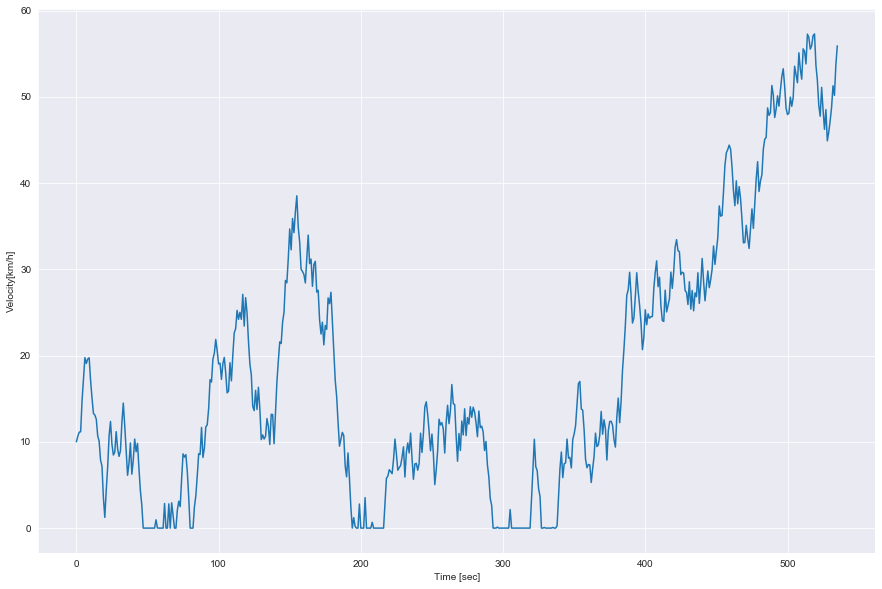

In [330]:
plt.figure(figsize=(15,10))
plt.plot(gdc_r_2["velocity"])
#plt.plot(gdc["acc"])
plt.grid(True)
plt.xlabel('Time [sec]') 
plt.ylabel('Velocity[km/h]')
plt.show()

### Driving characteristic parameters for Rural (Generated and Original)

----------------------------------------------------------------------------
                                   Real-world data  Generated drive cycle
Proportion of Idel (%)                       6.140                  3.170
Proportion of Acceleration (%)              45.560                 49.810
Proportion of Deceleration (%)              40.340                 37.130
Proportion of Cruise (%)                     7.870                  9.890
Proportion of Creep (%)                      0.090                  0.000
STD of velocity                             15.660                 13.484
Maximum of velocity ( km / h )              75.900                 63.270
Minimum of velocity ( km / h )               0.000                  0.000
Mean of velocity ( km / h )                 31.738                 42.615
STD of acceleration                          1.748                  1.439
Maximum of acceleration ( m/ s2 )            9.330                  5.840
Minimum of acceleration ( m/ s2 )  

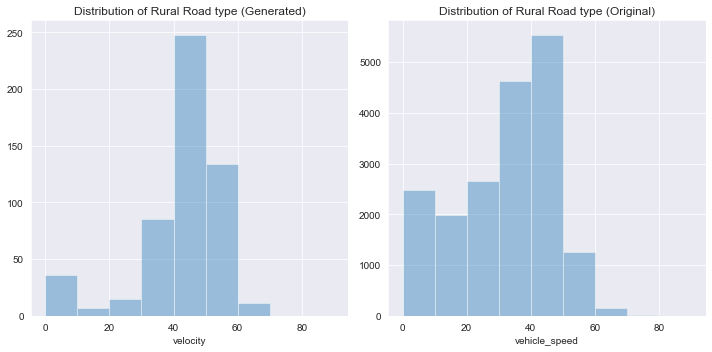

In [351]:
    prop_mdf_i = round(len(gdc_r_18[gdc_r_18.mdf=='i'])/len(gdc_r_18)*100,2)
    prop_mdf_a = round(len(gdc_r_18[gdc_r_18.mdf=='a'])/len(gdc_r_18)*100,2)
    prop_mdf_d = round(len(gdc_r_18[gdc_r_18.mdf=='d'])/len(gdc_r_18)*100,2)
    prop_mdf_c = round(len(gdc_r_18[gdc_r_18.mdf=='c'])/len(gdc_r_18)*100,2)
    prop_mdf_k = round(len(gdc_r_18[gdc_r_18.mdf=='k'])/len(gdc_r_18)*100,2)
    prop_org_mdf_i = round(len(rural_full[rural_full.state=='i'])/len(rural_full)*100,2)
    prop_org_mdf_a = round(len(rural_full[rural_full.state=='a'])/len(rural_full)*100,2)
    prop_org_mdf_d = round(len(rural_full[rural_full.state=='d'])/len(rural_full)*100,2)
    prop_org_mdf_c = round(len(rural_full[rural_full.state=='c'])/len(rural_full)*100,2)
    prop_org_mdf_k = round(len(rural_full[rural_full.state=='k'])/len(rural_full)*100,2)
    
    df_g = gdc_r_18[['velocity','acc']].describe().reset_index()
    df_r = rural_full[['vehicle_speed','accel']].describe().reset_index()
    std_gen_v = np.asscalar(df_g[2:3]['velocity'])
    max_gen_v = np.asscalar(df_g[7:8]['velocity'])
    min_gen_v = np.asscalar(df_g[3:4]['velocity'])
    mean_gen_v = np.asscalar(df_g[1:2]['velocity'])

    std_gen_a = np.asscalar(df_g[2:3]['acc'])
    max_gen_a = np.asscalar(df_g[7:8]['acc'])
    min_gen_a = np.asscalar(df_g[3:4]['acc'])
    mean_gen_a = np.asscalar(df_g[1:2]['acc'])
    
    std_org_v = np.asscalar(df_r[2:3]['vehicle_speed'])
    max_org_v = np.asscalar(df_r[7:8]['vehicle_speed'])
    min_org_v = np.asscalar(df_r[3:4]['vehicle_speed'])
    mean_org_v = np.asscalar(df_r[1:2]['vehicle_speed'])

    std_org_a = np.asscalar(df_r[2:3]['accel'])
    max_org_a = np.asscalar(df_r[7:8]['accel'])
    min_org_a = np.asscalar(df_r[3:4]['accel'])
    mean_org_a = np.asscalar(df_r[1:2]['accel'])
    
    Parameters = ['Proportion of Idel (%)','Proportion of Acceleration (%)','Proportion of Deceleration (%)',
              'Proportion of Cruise (%)','Proportion of Creep (%)',
             'STD of velocity','Maximum of velocity ( km / h )','Minimum of velocity ( km / h )',
             'Mean of velocity ( km / h )','STD of acceleration','Maximum of acceleration ( m/ s2 )',
              'Minimum of acceleration ( m/ s2 )','Mean of acceleration ( m/ s2 )']

    val = pd.DataFrame(columns = ['Real-world data', 'Generated drive cycle'],index=Parameters)
    val['Real-world data'] = [ prop_org_mdf_i,prop_org_mdf_a,  prop_org_mdf_d,prop_org_mdf_c,prop_org_mdf_k,std_org_v, max_org_v,
                             min_org_v, mean_org_v, std_org_a, max_org_a, min_org_a, mean_org_a ]
    val['Generated drive cycle'] = [ prop_mdf_i, prop_mdf_a, prop_mdf_d, prop_mdf_c, prop_mdf_k,
                                   std_gen_v, max_gen_v, min_gen_v, mean_gen_v, std_gen_a, max_gen_a, min_gen_a,
                                   mean_gen_a]
    
print('----------------------------------------------------------------------------')
    print(val)
    


f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.distplot(gdc_r_18['velocity'].dropna(),bins=[0,10,20,30,40,50,60,70,80,90], kde=False, ax=axes[0])
axes[0].set_title("Distribution of Rural Road type (Generated)")

print('----------------------------------------------------------------------------')
sns.distplot(rural_full['vehicle_speed'].dropna(),bins=[0,10,20,30,40,50,60,70,80,90], kde=False, ax=axes[1])
axes[1].set_title("Distribution of Rural Road type (Original)")

plt.tight_layout()

#### MOTORWAY

In [253]:
transitions_m = pd.Series(motorway_full['state_vel']).dropna()

transitions_m = [round(x) for x in transitions_m]


In [254]:
def transition__atrix(transitions):
    n = 1+max(transitions) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

#test:


m_m = transition__atrix(transitions_m)
#for row in m: print(' '.join('{0:.3f}'.format(x) for x in row))

In [255]:
transition_matrix_m_ = np.array(m_m)

pd.options.display.float_format = '{:,.3f}'.format
transition_matrix_m = pd.DataFrame(transition_matrix_m_, columns=['v0', 'v1', 'v2','v3','v4','v5','v6','v7','v8','v9','v10'
                                                                 ,'v11','v12','v13','v14'])
transition_matrix_m.index = transition_matrix_m.columns
transition_matrix_m

v0    v1    v2    v3    v4    v5    v6    v7    v8    v9   v10   v11  \
v0  0.873 0.109 0.000 0.000 0.000 0.000 0.006 0.006 0.006 0.000 0.000 0.000   
v1  0.122 0.619 0.252 0.007 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
v2  0.005 0.166 0.653 0.171 0.005 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
v3  0.000 0.011 0.175 0.559 0.254 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
v4  0.006 0.000 0.017 0.221 0.506 0.250 0.000 0.000 0.000 0.000 0.000 0.000   
v5  0.000 0.000 0.000 0.018 0.157 0.585 0.240 0.000 0.000 0.000 0.000 0.000   
v6  0.000 0.000 0.000 0.000 0.017 0.144 0.638 0.201 0.000 0.000 0.000 0.000   
v7  0.000 0.000 0.000 0.000 0.000 0.011 0.139 0.685 0.163 0.003 0.000 0.000   
v8  0.000 0.000 0.000 0.002 0.000 0.000 0.007 0.123 0.684 0.183 0.000 0.000   
v9  0.000 0.000 0.000 0.000 0.000 0.000 0.002 0.008 0.099 0.767 0.125 0.000   
v10 0.001 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.006 0.098 0.791 0.105   
v11 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.007 0.120 0.761   
v12 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.005 0.097   
v13 0.002 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.002 0.002   
v14 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   

      v12   v13   v14  
v0  0.000 0.000 0.000  
v1  0.000 0.000 0.000  
v2  0.000 0.000 0.000  
v3  0.000 0.000 0.000  
v4  0.000 0.000 0.000  
v5  0.000 0.000 0.000  
v6  0.000 0.000 0.000  
v7  0.000 0.000 0.000  
v8  0.000 0.000 0.000  
v9  0.000 0.000 0.000  
v10 0.000 0.000 0.000  
v11 0.111 0.000 0.000  
v12 0.802 0.095 0.000  
v13 0.096 0.830 0.068  
v14 0.005 0.076 0.919

In [256]:
chain = MarkovChain(transition_matrix=transition_matrix_m, states=['v0', 'v1', 'v2','v3','v4','v5','v6','v7','v8','v9','v10'
                                                                 ,'v11','v12','v13','v14'])

In [257]:
gen_seq_m = np.array(chain.generate_states(current_state='v0', no=50000))


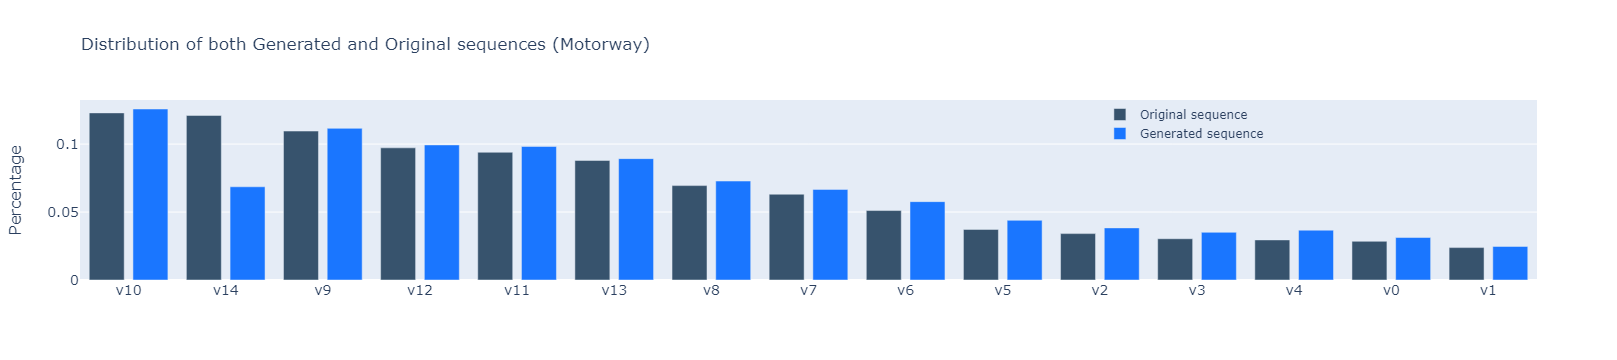

In [258]:
import plotly.graph_objects as go
gen_m = pd.Series(gen_seq_m).sort_values()
org_m = pd.Series(original_seq_m).sort_values()


index=org_m.value_counts().index.tolist()
index1=gen_m.value_counts().index.tolist()
# gw = g.value_counts().tolist()
# gow = g_o.value_counts().tolist()
gw = np.divide(gen_m.value_counts().tolist(),len(gen_m))
gow = np.divide(org_m.value_counts().tolist(),len(org_m))

fig = go.Figure()
fig.add_trace(go.Bar(x=index,
                y=gow,
                name='Original sequence',
                marker_color='rgb(55, 83, 109)'
                ))
fig.add_trace(go.Bar(x=index1,
                y=gw,
                name='Generated sequence',
                marker_color='rgb(26, 118, 255)'
                ))

fig.update_layout(
    title='Distribution of both Generated and Original sequences (Motorway)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Percentage',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=.7,
        y=1.0,
        bgcolor='rgba(255, 25, 25, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.1, # gap between bars of adjacent location coordinates.
    bargroupgap=0.2 # gap between bars of the same location coordinate.
)
fig.show()

In [259]:
mse = metrics.mean_squared_error(gow*100,gw*100)
print('RMSE for Motorway : ',np.sqrt(mse))

RMSE for Motorway :  0.6601752106439757


### Driving characteristic parameters for motorway (Original)

-------------------------------------------------------
motorway Proportion in the Data :  13.92244878468077
-------------------------------------------------------
Percentage(%) of Driving state 'i' : 1.646372834848225
Percentage(%) of Driving state 'a' : 50.780312124849935
Percentage(%) of Driving state 'd' : 40.216086434573825
Percentage(%) of Driving state 'c' : 7.322929171668667
Percentage(%) of Driving state 'k' : 0.034299434059338024
-------------------------------------------------------
Minimum value of speed :  0.0
Maximum value of speed :  87.95
Average value of speed :  48.01453781512655
-------------------------------------------------------
RMS of Acceleration :  1.9203336535893603
-------------------------------------------------------


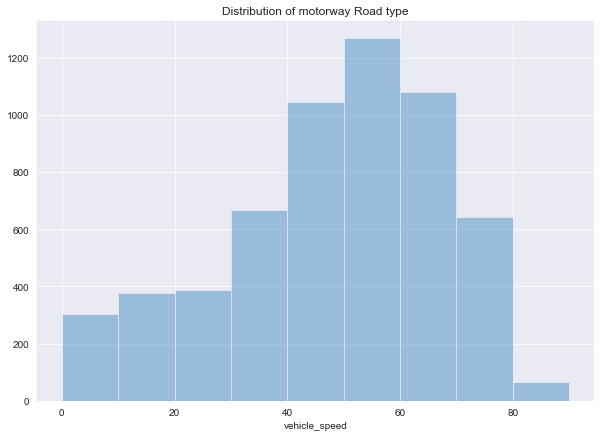

In [260]:
print('-------------------------------------------------------')
print('motorway Proportion in the Data : ', len(motorway_full)/len(full_data)*100)
print('-------------------------------------------------------')
print("Percentage(%) of Driving state 'i' :", len(motorway_full[motorway_full['state'] =='i'])/len(motorway_full)*100)
print("Percentage(%) of Driving state 'a' :", len(motorway_full[motorway_full['state'] =='a'])/len(motorway_full)*100)
print("Percentage(%) of Driving state 'd' :", len(motorway_full[motorway_full['state'] =='d'])/len(motorway_full)*100)
print("Percentage(%) of Driving state 'c' :", len(motorway_full[motorway_full['state'] =='c'])/len(motorway_full)*100)
print("Percentage(%) of Driving state 'k' :", len(motorway_full[motorway_full['state'] =='k'])/len(motorway_full)*100)
print('-------------------------------------------------------')
print('Minimum value of speed : ', motorway_full['vehicle_speed'].min())
print('Maximum value of speed : ', motorway_full['vehicle_speed'].max())
print('Average value of speed : ', motorway_full['vehicle_speed'].mean())
print('-------------------------------------------------------')
print('RMS of Acceleration : ' ,np.sqrt(np.mean(motorway_full['accel'].dropna()**2)))
print('-------------------------------------------------------')
plt.figure(figsize=(10,7))
sns.distplot(motorway_full['vehicle_speed'].dropna(),bins=[0,10,20,30,40,50,60,70,80,90], kde=False)
plt.title("Distribution of motorway Road type")
plt.show()

### Cumulative TPM for motorway

In [261]:
#np.set_printoptions(precision=5,suppress=True)
cum_tpm_m = np.cumsum(transition_matrix_m_,axis=1)

pd.options.display.float_format = '{:,.3f}'.format
cum_tpm1 = pd.DataFrame(cum_tpm_m, columns=['v0', 'v1', 'v2','v3','v4','v5','v6','v7','v8','v9','v10'
                                                                 ,'v11','v12','v13','v14'])
cum_tpm1.index = cum_tpm1.columns
cum_tpm1

v0    v1    v2    v3    v4    v5    v6    v7    v8    v9   v10   v11  \
v0  0.873 0.982 0.982 0.982 0.982 0.982 0.988 0.994 1.000 1.000 1.000 1.000   
v1  0.122 0.741 0.993 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
v2  0.005 0.171 0.824 0.995 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
v3  0.000 0.011 0.186 0.746 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
v4  0.006 0.006 0.023 0.244 0.750 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
v5  0.000 0.000 0.000 0.018 0.175 0.760 1.000 1.000 1.000 1.000 1.000 1.000   
v6  0.000 0.000 0.000 0.000 0.017 0.161 0.799 1.000 1.000 1.000 1.000 1.000   
v7  0.000 0.000 0.000 0.000 0.000 0.011 0.149 0.834 0.997 1.000 1.000 1.000   
v8  0.000 0.000 0.000 0.002 0.002 0.002 0.010 0.133 0.817 1.000 1.000 1.000   
v9  0.000 0.000 0.000 0.000 0.000 0.000 0.002 0.009 0.108 0.875 1.000 1.000   
v10 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.007 0.105 0.895 1.000   
v11 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.007 0.128 0.889   
v12 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.005 0.102   
v13 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.004 0.006   
v14 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   

      v12   v13   v14  
v0  1.000 1.000 1.000  
v1  1.000 1.000 1.000  
v2  1.000 1.000 1.000  
v3  1.000 1.000 1.000  
v4  1.000 1.000 1.000  
v5  1.000 1.000 1.000  
v6  1.000 1.000 1.000  
v7  1.000 1.000 1.000  
v8  1.000 1.000 1.000  
v9  1.000 1.000 1.000  
v10 1.000 1.000 1.000  
v11 1.000 1.000 1.000  
v12 0.905 1.000 1.000  
v13 0.101 0.932 1.000  
v14 0.005 0.081 1.000

In [344]:
def drive_cycle_m(road_type, full_data,cum_tpm):
    curr_cycle_vel = [20]
    curr_cycle_acc = [1.5]
    curr_cycle_mdf = ['a']
    c = 0

    def appen_vel(ch_in_vel):
        curr_cycle_vel.append(np.asscalar(ch_in_vel)) 
        return curr_cycle_vel[c+1]

    def appen_mdf(ch_mdf):
        curr_cycle_mdf.append(np.asscalar(ch_mdf)) 
        return curr_cycle_mdf[c+1]

    def appen_acc(ch_in_acc):
        curr_cycle_acc.append(np.asscalar(ch_in_acc)) 
        return curr_cycle_acc[c+1]

    while len(curr_cycle_vel)< round(1200*len(road_type)/len(full_data)):


        i = np.asscalar(np.array(random.sample(np.arange(0,len(cum_tpm)).tolist(),1)))
        rr = np.random.uniform()
        int_st = bisect.bisect_left(cum_tpm[i,],rr)

        mdf_with_speed_ch = full_data[full_data['state_vel']==int_st]
        mdf_with_speed_ch = mdf_with_speed_ch[['state','vehicle_speed','accel']].sample()

        ch_in_vel = mdf_with_speed_ch['vehicle_speed']
        ch_in_acc = mdf_with_speed_ch['accel']
        #print(ch_in_vel)
        ch_mdf = mdf_with_speed_ch['state']
        #print(curr_cycle_vel)   

       #Compute difference
        spfic_val = 4.9

        delta = abs(np.subtract(np.asscalar(ch_in_vel) , curr_cycle_vel[c]))
        #print(delta)
        if delta < spfic_val:
            appen_vel(ch_in_vel)
            appen_mdf(ch_mdf)
            appen_acc(ch_in_acc)
            c +=1
    
    gdc_m = pd.DataFrame(columns=['index', 'velocity','mdf','acc'])
    gdc_m['velocity'] = curr_cycle_vel
    gdc_m['mdf'] = curr_cycle_mdf
    gdc_m['acc'] = curr_cycle_acc
    gdc_m['index'] = gdc_m.index
    
    prop_mdf_i = round(len(gdc_m[gdc_m.mdf=='i'])/len(gdc_m)*100,2)
    prop_mdf_a = round(len(gdc_m[gdc_m.mdf=='a'])/len(gdc_m)*100,2)
    prop_mdf_d = round(len(gdc_m[gdc_m.mdf=='d'])/len(gdc_m)*100,2)
    prop_mdf_c = round(len(gdc_m[gdc_m.mdf=='c'])/len(gdc_m)*100,2)
    prop_mdf_k = round(len(gdc_m[gdc_m.mdf=='k'])/len(gdc_m)*100,2)
    prop_org_mdf_i = round(len(full_data[full_data.state=='i'])/len(full_data)*100,2)
    prop_org_mdf_a = round(len(full_data[full_data.state=='a'])/len(full_data)*100,2)
    prop_org_mdf_d = round(len(full_data[full_data.state=='d'])/len(full_data)*100,2)
    prop_org_mdf_c = round(len(full_data[full_data.state=='c'])/len(full_data)*100,2)
    prop_org_mdf_k = round(len(full_data[full_data.state=='k'])/len(full_data)*100,2)
    
    df_g = gdc_m[['velocity','acc']].describe().reset_index()
    df_r = full_data[['vehicle_speed','accel']].describe().reset_index()
    std_gen_v = np.asscalar(df_g[2:3]['velocity'])
    max_gen_v = np.asscalar(df_g[7:8]['velocity'])
    min_gen_v = np.asscalar(df_g[3:4]['velocity'])
    mean_gen_v = np.asscalar(df_g[1:2]['velocity'])

    std_gen_a = np.asscalar(df_g[2:3]['acc'])
    max_gen_a = np.asscalar(df_g[7:8]['acc'])
    min_gen_a = np.asscalar(df_g[3:4]['acc'])
    mean_gen_a = np.asscalar(df_g[1:2]['acc'])
    
    std_org_v = np.asscalar(df_r[2:3]['vehicle_speed'])
    max_org_v = np.asscalar(df_r[7:8]['vehicle_speed'])
    min_org_v = np.asscalar(df_r[3:4]['vehicle_speed'])
    mean_org_v = np.asscalar(df_r[1:2]['vehicle_speed'])

    std_org_a = np.asscalar(df_r[2:3]['accel'])
    max_org_a = np.asscalar(df_r[7:8]['accel'])
    min_org_a = np.asscalar(df_r[3:4]['accel'])
    mean_org_a = np.asscalar(df_r[1:2]['accel'])
    
    Parameters = ['Proportion of Idel (%)','Proportion of Acceleration (%)','Proportion of Deceleration (%)',
              'Proportion of Cruise (%)','Proportion of Creep (%)',
             'STD of velocity','Maximum of velocity ( km / h )','Minimum of velocity ( km / h )',
             'Mean of velocity ( km / h )','STD of acceleration','Maximum of acceleration ( m/ s2 )',
              'Minimum of acceleration ( m/ s2 )','Mean of acceleration ( m/ s2 )']

    val = pd.DataFrame(columns = ['Real-world data', 'Generated drive cycle'],index=Parameters)
    val['Real-world data'] = [ prop_org_mdf_i,prop_org_mdf_a,  prop_org_mdf_d,prop_org_mdf_c,prop_org_mdf_k,std_org_v, max_org_v,
                             min_org_v, mean_org_v, std_org_a, max_org_a, min_org_a, mean_org_a ]
    val['Generated drive cycle'] = [ prop_mdf_i, prop_mdf_a, prop_mdf_d, prop_mdf_c, prop_mdf_k,
                                   std_gen_v, max_gen_v, min_gen_v, mean_gen_v, std_gen_a, max_gen_a, min_gen_a,
                                   mean_gen_a]
    
    real_world_para  = val['Real-world data'].tolist()
    gen_para = val['Generated drive cycle'].tolist()
    real_world_para=[0.01 if x==0.0 else x for x in real_world_para]
    
    n = len(real_world_para) 
    for i in range (0,n):  
        s = np.sum((((gen_para[i] - real_world_para[i])**2) /  real_world_para[i])) 
    RMSRE = (s/n)*100
    print("RMSRE : ", RMSRE)
    
    return gdc_m 

## Monte carlo simulation(N times) with corresponding RMSRE:

In [263]:
for i in range(20):
    print(i)
    exec(f'gdc_m_{i} = drive_cycle_m(motorway_full, full_data,cum_tpm_m)')


0


C:\Users\u23e00\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\type_check.py:547: FutureWarning:

`item` has been deprecated and will be removed in a future version



RMSRE :  16.574804912257214
1
RMSRE :  46.762693724513525
2
RMSRE :  0.18638642796218866
3
RMSRE :  52.95855658945933
4
RMSRE :  16.82913374440322
5
RMSRE :  6.9220902585353326
6
RMSRE :  15.454288378954622
7
RMSRE :  35.831544534644685
8
RMSRE :  18.167698145370636
9
RMSRE :  54.63792524976348
10
RMSRE :  7.777347117812374
11
RMSRE :  0.07443733026355469
12
RMSRE :  162.4022263823351
13
RMSRE :  10.346607457850707
14
RMSRE :  225.9233024111265
15
RMSRE :  81.25631586907501
16
RMSRE :  1.5979526651867144
17
RMSRE :  75.35701661788256
18
RMSRE :  0.6790274550404005
19
RMSRE :  1.365464000463896


### Generated Drive cycle for motorway

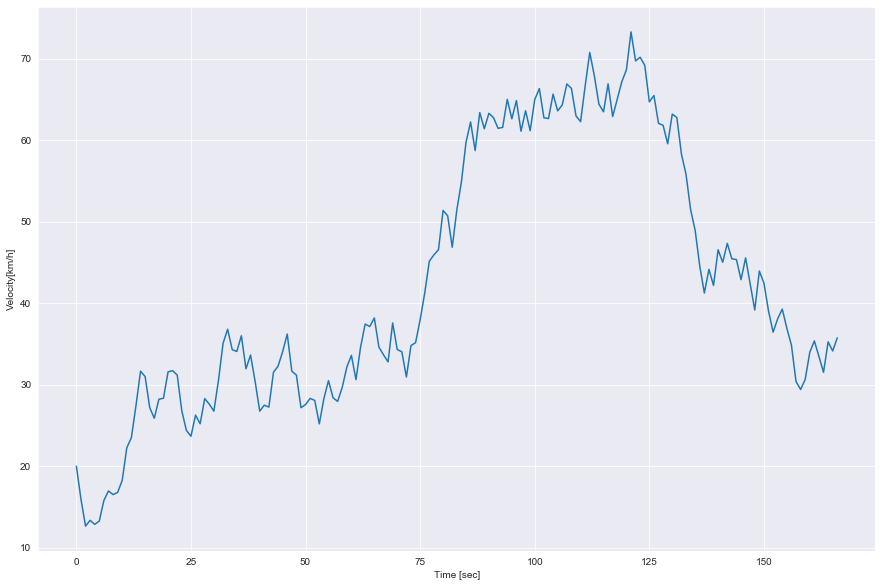

In [297]:
plt.figure(figsize=(15,10))
plt.plot(gdc_m_19["velocity"])
#plt.plot(gdc["acc"])
plt.grid(True)
plt.xlabel('Time [sec]') 
plt.ylabel('Velocity[km/h]')
plt.show()

### Driving characteristic parameters for Motorway (Generated)

----------------------------------------------------------------------------
                                   Real-world data  Generated drive cycle
Proportion of Idel (%)                       1.650                  0.000
Proportion of Acceleration (%)              50.780                 50.300
Proportion of Deceleration (%)              40.220                 43.110
Proportion of Cruise (%)                     7.320                  6.590
Proportion of Creep (%)                      0.030                  0.000
STD of velocity                             19.577                 16.127
Maximum of velocity ( km / h )              87.950                 73.310
Minimum of velocity ( km / h )               0.000                 12.640
Mean of velocity ( km / h )                 48.015                 42.296
STD of acceleration                          1.920                  1.594
Maximum of acceleration ( m/ s2 )            7.870                  4.880
Minimum of acceleration ( m/ s2 )  

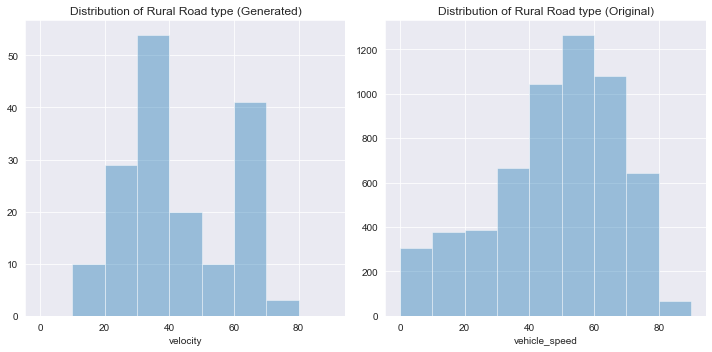

In [352]:
    prop_mdf_i = round(len(gdc_m_19[gdc_m_19.mdf=='i'])/len(gdc_m_19)*100,2)
    prop_mdf_a = round(len(gdc_m_19[gdc_m_19.mdf=='a'])/len(gdc_m_19)*100,2)
    prop_mdf_d = round(len(gdc_m_19[gdc_m_19.mdf=='d'])/len(gdc_m_19)*100,2)
    prop_mdf_c = round(len(gdc_m_19[gdc_m_19.mdf=='c'])/len(gdc_m_19)*100,2)
    prop_mdf_k = round(len(gdc_m_19[gdc_m_19.mdf=='k'])/len(gdc_m_19)*100,2)
    prop_org_mdf_i = round(len(motorway_full[motorway_full.state=='i'])/len(motorway_full)*100,2)
    prop_org_mdf_a = round(len(motorway_full[motorway_full.state=='a'])/len(motorway_full)*100,2)
    prop_org_mdf_d = round(len(motorway_full[motorway_full.state=='d'])/len(motorway_full)*100,2)
    prop_org_mdf_c = round(len(motorway_full[motorway_full.state=='c'])/len(motorway_full)*100,2)
    prop_org_mdf_k = round(len(motorway_full[motorway_full.state=='k'])/len(motorway_full)*100,2)
    
    df_g = gdc_m_19[['velocity','acc']].describe().reset_index()
    df_r = motorway_full[['vehicle_speed','accel']].describe().reset_index()
    std_gen_v = np.asscalar(df_g[2:3]['velocity'])
    max_gen_v = np.asscalar(df_g[7:8]['velocity'])
    min_gen_v = np.asscalar(df_g[3:4]['velocity'])
    mean_gen_v = np.asscalar(df_g[1:2]['velocity'])

    std_gen_a = np.asscalar(df_g[2:3]['acc'])
    max_gen_a = np.asscalar(df_g[7:8]['acc'])
    min_gen_a = np.asscalar(df_g[3:4]['acc'])
    mean_gen_a = np.asscalar(df_g[1:2]['acc'])
    
    std_org_v = np.asscalar(df_r[2:3]['vehicle_speed'])
    max_org_v = np.asscalar(df_r[7:8]['vehicle_speed'])
    min_org_v = np.asscalar(df_r[3:4]['vehicle_speed'])
    mean_org_v = np.asscalar(df_r[1:2]['vehicle_speed'])

    std_org_a = np.asscalar(df_r[2:3]['accel'])
    max_org_a = np.asscalar(df_r[7:8]['accel'])
    min_org_a = np.asscalar(df_r[3:4]['accel'])
    mean_org_a = np.asscalar(df_r[1:2]['accel'])
    
    Parameters = ['Proportion of Idel (%)','Proportion of Acceleration (%)','Proportion of Deceleration (%)',
              'Proportion of Cruise (%)','Proportion of Creep (%)',
             'STD of velocity','Maximum of velocity ( km / h )','Minimum of velocity ( km / h )',
             'Mean of velocity ( km / h )','STD of acceleration','Maximum of acceleration ( m/ s2 )',
              'Minimum of acceleration ( m/ s2 )','Mean of acceleration ( m/ s2 )']

    val = pd.DataFrame(columns = ['Real-world data', 'Generated drive cycle'],index=Parameters)
    val['Real-world data'] = [ prop_org_mdf_i,prop_org_mdf_a,  prop_org_mdf_d,prop_org_mdf_c,prop_org_mdf_k,std_org_v, max_org_v,
                             min_org_v, mean_org_v, std_org_a, max_org_a, min_org_a, mean_org_a ]
    val['Generated drive cycle'] = [ prop_mdf_i, prop_mdf_a, prop_mdf_d, prop_mdf_c, prop_mdf_k,
                                   std_gen_v, max_gen_v, min_gen_v, mean_gen_v, std_gen_a, max_gen_a, min_gen_a,
                                   mean_gen_a]
    
print('----------------------------------------------------------------------------')
    print(val)
    


f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.distplot(gdc_m_19['velocity'].dropna(),bins=[0,10,20,30,40,50,60,70,80,90], kde=False, ax=axes[0])
axes[0].set_title("Distribution of Rural Road type (Generated)")

print('----------------------------------------------------------------------------')
sns.distplot(motorway_full['vehicle_speed'].dropna(),bins=[0,10,20,30,40,50,60,70,80,90], kde=False, ax=axes[1])
axes[1].set_title("Distribution of Rural Road type (Original)")

plt.tight_layout()

In [425]:
gd = pd.DataFrame(columns=['index', 'velocity','mdf','acc'])
gd['velocity'] = pd.Series(np.zeros(10))
gd['mdf'] = pd.Series(["i","i","i","i","i","i","i","i","i","i"])
gd['acc'] = pd.Series(np.zeros(10))
gd['index'] = gd.index

# Final Drive cycle:

In [449]:
final_dc = pd.concat([gdc_u_16,gdc_r_2,gdc_m_19,gd],ignore_index=True, sort =False)
final_dc.loc[final_dc['velocity'] <4, 'velocity'] = 0
final_dc['velocity'] = final_dc['velocity'].rolling(window=7).mean()

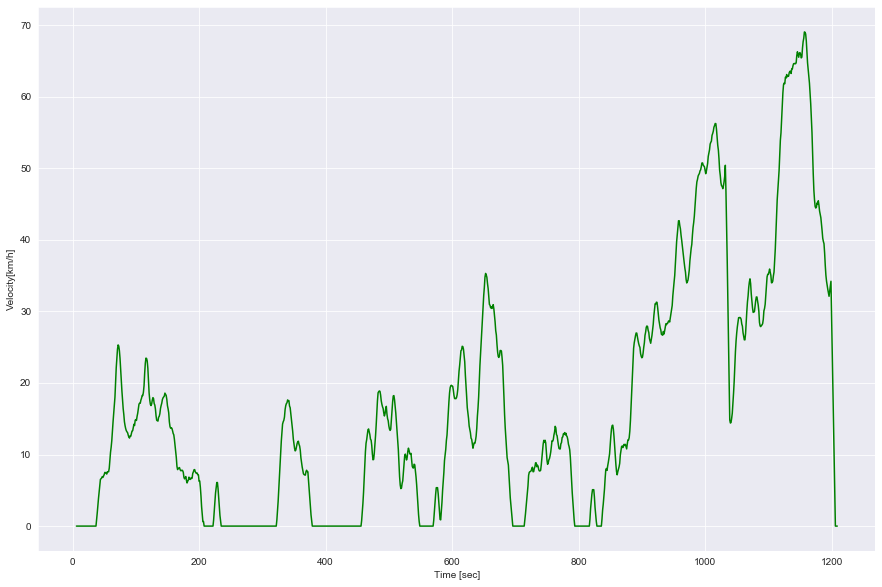

In [450]:
plt.figure(figsize=(15,10))
plt.plot(final_dc["velocity"],'g')
#plt.plot(gdc["acc"])
plt.grid(True)
plt.xlabel('Time [sec]') 
plt.ylabel('Velocity[km/h]')
plt.show()

----------------------------------------------------------------------------
                                   Real-world data  Generated drive cycle
Proportion of Idel (%)                      16.900                 21.900
Proportion of Acceleration (%)              40.290                 38.100
Proportion of Deceleration (%)              36.300                 34.460
Proportion of Cruise (%)                     6.140                  5.370
Proportion of Creep (%)                      0.370                  0.170
STD of velocity                             20.230                 17.164
Maximum of velocity ( km / h )              87.950                 69.057
Minimum of velocity ( km / h )               0.000                  0.000
Mean of velocity ( km / h )                 25.250                 16.700
STD of acceleration                          1.744                  1.842
Maximum of acceleration ( m/ s2 )            9.330                  6.570
Minimum of acceleration ( m/ s2 )  

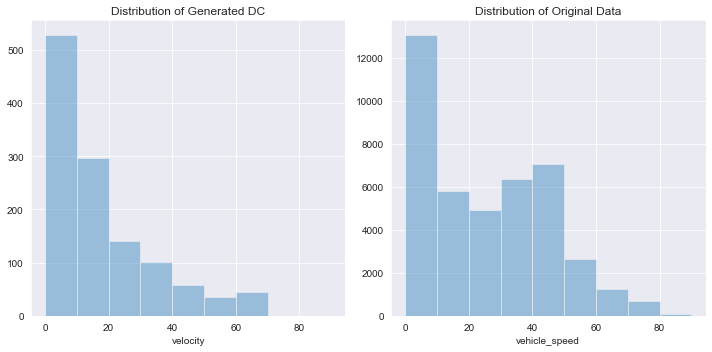

In [451]:
prop_mdf_i = round(len(final_dc[final_dc.mdf=='i'])/len(final_dc)*100,2)
prop_mdf_a = round(len(final_dc[final_dc.mdf=='a'])/len(final_dc)*100,2)
prop_mdf_d = round(len(final_dc[final_dc.mdf=='d'])/len(final_dc)*100,2)
prop_mdf_c = round(len(final_dc[final_dc.mdf=='c'])/len(final_dc)*100,2)
prop_mdf_k = round(len(final_dc[final_dc.mdf=='k'])/len(final_dc)*100,2)
prop_org_mdf_i = round(len(full_data[full_data.state=='i'])/len(full_data)*100,2)
prop_org_mdf_a = round(len(full_data[full_data.state=='a'])/len(full_data)*100,2)
prop_org_mdf_d = round(len(full_data[full_data.state=='d'])/len(full_data)*100,2)
prop_org_mdf_c = round(len(full_data[full_data.state=='c'])/len(full_data)*100,2)
prop_org_mdf_k = round(len(full_data[full_data.state=='k'])/len(full_data)*100,2)
    
df_g = final_dc[['velocity','acc']].describe().reset_index()
df_r = full_data[['vehicle_speed','accel']].describe().reset_index()
std_gen_v = np.asscalar(df_g[2:3]['velocity'])
max_gen_v = np.asscalar(df_g[7:8]['velocity'])
min_gen_v = np.asscalar(df_g[3:4]['velocity'])
mean_gen_v = np.asscalar(df_g[1:2]['velocity'])

std_gen_a = np.asscalar(df_g[2:3]['acc'])
max_gen_a = np.asscalar(df_g[7:8]['acc'])
min_gen_a = np.asscalar(df_g[3:4]['acc'])
mean_gen_a = np.asscalar(df_g[1:2]['acc'])

std_org_v = np.asscalar(df_r[2:3]['vehicle_speed'])
max_org_v = np.asscalar(df_r[7:8]['vehicle_speed'])
min_org_v = np.asscalar(df_r[3:4]['vehicle_speed'])
mean_org_v = np.asscalar(df_r[1:2]['vehicle_speed'])

std_org_a = np.asscalar(df_r[2:3]['accel'])
max_org_a = np.asscalar(df_r[7:8]['accel'])
min_org_a = np.asscalar(df_r[3:4]['accel'])
mean_org_a = np.asscalar(df_r[1:2]['accel'])

Parameters = ['Proportion of Idel (%)','Proportion of Acceleration (%)','Proportion of Deceleration (%)',
          'Proportion of Cruise (%)','Proportion of Creep (%)',
         'STD of velocity','Maximum of velocity ( km / h )','Minimum of velocity ( km / h )',
         'Mean of velocity ( km / h )','STD of acceleration','Maximum of acceleration ( m/ s2 )',
          'Minimum of acceleration ( m/ s2 )','Mean of acceleration ( m/ s2 )']

val = pd.DataFrame(columns = ['Real-world data', 'Generated drive cycle'],index=Parameters)
val['Real-world data'] = [ prop_org_mdf_i,prop_org_mdf_a,  prop_org_mdf_d,prop_org_mdf_c,prop_org_mdf_k,std_org_v, max_org_v,
                         min_org_v, mean_org_v, std_org_a, max_org_a, min_org_a, mean_org_a ]
val['Generated drive cycle'] = [ prop_mdf_i, prop_mdf_a, prop_mdf_d, prop_mdf_c, prop_mdf_k,
                               std_gen_v, max_gen_v, min_gen_v, mean_gen_v, std_gen_a, max_gen_a, min_gen_a,
                               mean_gen_a]

print('----------------------------------------------------------------------------')
print(val)
    


f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.distplot(final_dc['velocity'].dropna(),bins=[0,10,20,30,40,50,60,70,80,90], kde=False, ax=axes[0])
axes[0].set_title("Distribution of Generated DC")

print('----------------------------------------------------------------------------')
sns.distplot(full_data['vehicle_speed'].dropna(),bins=[0,10,20,30,40,50,60,70,80,90], kde=False, ax=axes[1])
axes[1].set_title("Distribution of Original Data")



real_world_para  = val['Real-world data'].tolist()
gen_para = val['Generated drive cycle'].tolist()
real_world_para=[0.01 if x==0.0 else x for x in real_world_para]

n = len(real_world_para) 
for i in range (0,n):  
    s = np.sum((((gen_para[i] - real_world_para[i])**2) /  real_world_para[i])) 
    RMSRE = (s/n)*100
print("RMSRE : ", RMSRE)
print('----------------------------------------------------------------------------')    

plt.tight_layout()

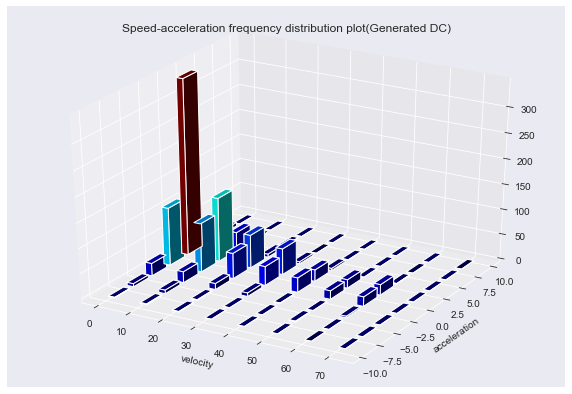

In [452]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

hist, xedges, yedges = np.histogram2d(final_dc["velocity"], final_dc["acc"], bins=8, range=[[0,80], [-10, 10]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + .25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 2 * np.ones_like(zpos)
dz = hist.ravel()

cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 


ax.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba)
plt.title('Speed-acceleration frequency distribution plot(Generated DC)')
plt.xlabel('velocity')
plt.ylabel('acceleration')

plt.show()

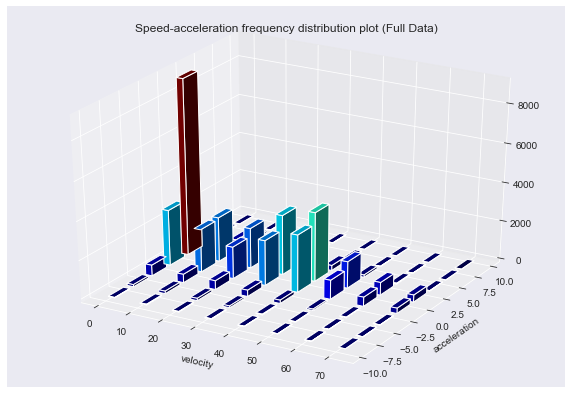

In [453]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

hist, xedges, yedges = np.histogram2d(full_data["vehicle_speed"], full_data["accel"], bins=8, range=[[0,80], [-10, 10]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 2 * np.ones_like(zpos)
dz = hist.ravel()

cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz,color=rgba)
plt.title('Speed-acceleration frequency distribution plot (Full Data)')
plt.xlabel('velocity')
plt.ylabel('acceleration')
plt.show()